<a href="https://colab.research.google.com/github/doongjinn/pose-estimation/blob/main/Golf_pose_estimation_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !nvidia-smi

Tue Sep 12 06:39:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
!nvcc --version  #cuda 버전 확인
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118


In [ ]:
import os
HOME = os.getcwd()  #getcwd == get current working directoty
print(HOME)


/content


In [ ]:
%cd {HOME}
!git clone https://github.com/WongKinYiu/yolov7

/content
Cloning into 'yolov7'...
remote: Enumerating objects: 1191, done.
remote: Total 1191 (delta 0), reused 0 (delta 0), pack-reused 1191
Receiving objects: 100% (1191/1191), 74.22 MiB | 13.11 MiB/s, done.
Resolving deltas: 100% (515/515), done.


In [ ]:
%cd {HOME}/yolov7
!pip install -r requirements.txt  #거기 있는 모든 파일 다운 받는다는 의미

/content/yolov7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append(f"{HOME}/yolov7")  # fstring 사용

In [ ]:
%cd {HOME}
!mkdir input # !mkdir -> make directory input이라는 새로운 directory 생성

/content


In [ ]:
import cv2
# %cd {HOME}/input
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1C2eVNmLN64nvpd3VQcFYuKR0jbyvIvdI' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1C2eVNmLN64nvpd3VQcFYuKR0jbyvIvdI" -O pose-estimation-synchronised-sample-a.mp4 && rm -rf /tmp/cookies.txt
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zEJ4EI-PlflNt90egfyNG8RxN6NNJ-WB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zEJ4EI-PlflNt90egfyNG8RxN6NNJ-WB" -O pose-estimation-synchronised-sample-b.mp4 && rm -rf /tmp/cookies.txt
# # !wget은 웹서버로부터 컨텐츠 가져오는 것것
SOURCE_VIDEO_A_PATH = ("/content/drive/MyDrive/data/school_data/공모전 골프 영상/편집영상/1번/정면 30fps(1).mp4")
SOURCE_VIDEO_B_PATH = ("/content/drive/MyDrive/data/school_data/공모전 골프 영상/편집영상/1번/측면 30fps(1).mp4")
SOURCE_VIDEO_C_PATH = ("/content/drive/MyDrive/data/school_data/공모전 골프 영상/편집영상/2번/정면 30fps 2.mp4")
SOURCE_VIDEO_D_PATH = ("/content/drive/MyDrive/data/school_data/공모전 골프 영상/편집영상/2번/측면 30fps(2).mp4")

In [ ]:
# SOURCE_VIDEO_A_PATH = f"{HOME}/input/pose-estimation-synchronised-sample-a.mp4"  # 1분 29초 영상 정면
# SOURCE_VIDEO_B_PATH = f"{HOME}/input/pose-estimation-synchronised-sample-b.mp4"  # 1분 29초 영상 측면

In [ ]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline
 #matplotlib 그래프를 바로 출력할수있게 한다.


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]: #-> 함수의 return 값을 주석하는 역활함
    video = cv2.VideoCapture(video_file)

    while video.isOpened():          # 비디오 캡처 객체가 잘 형성 되었는지
        success, frame = video.read()  # success -> true,false 반환, frame -> image(numpy.ndarray)

        if not success:
            break

        yield frame # yield는 return과 비슷하지만 하나하나씩 분리해서 return 가능  -> 그래서 첫번째 frame만 출력이 가능했던거임

    video.release()  # 마지막 오픈한 cap 객체 해체 반드시 해야하기 위한 코드


def plot_image(image: np.ndarray, size: int = 12) -> None:    #image 보여주기
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(image[...,::-1])   # 배열 안에 숫자들이 좌우 역순으로 바뀜
    plt.show()

In [ ]:
from typing import Optional, Tuple
from dataclasses import dataclass


@dataclass(frozen=True)  # frozen-> 불변 데이터(바꿀수 없게 만듬듬)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

@dataclass
class Detection:
    rect: Rect
    class_id: int
    confidence: float
    tracker_id: Optional[int] = None


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r


In [ ]:
import cv2

import numpy as np
#직사각형 그리는거 anntation하고 yolov7의 직사각형 박스 그리기
def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image

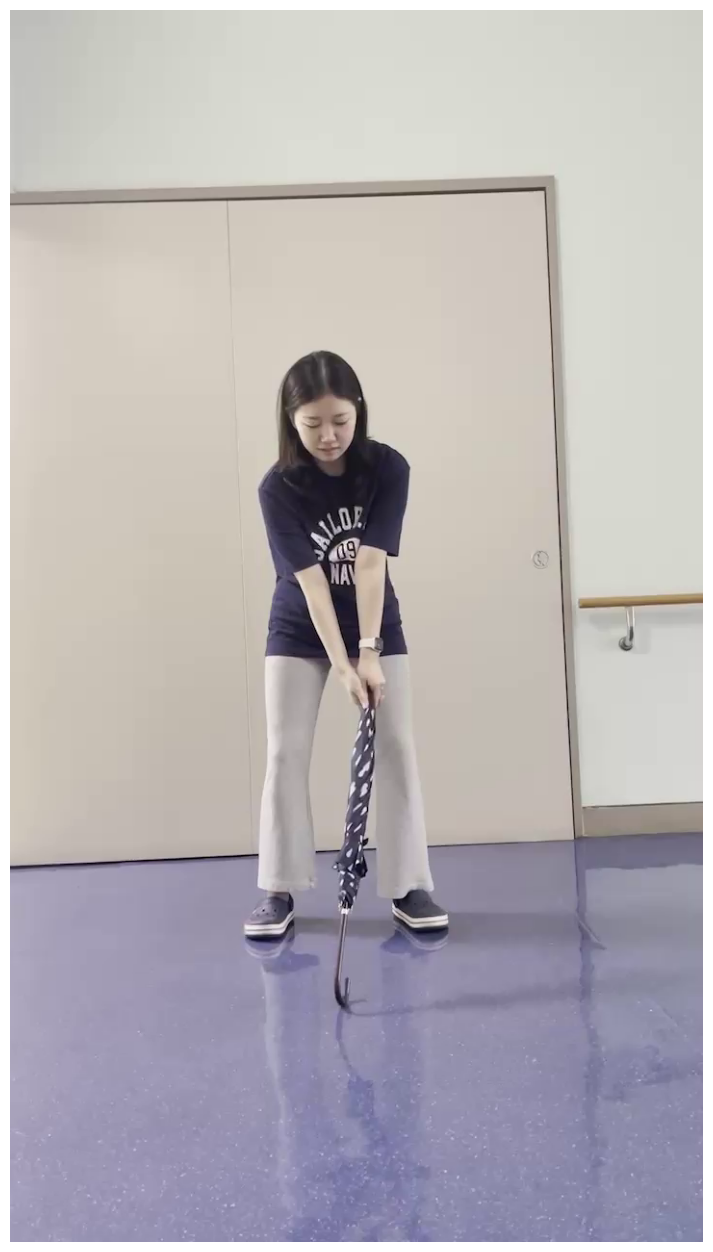

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))  # iter 한번 호출하면 값이 없어지고 next로 다음인자 하나씩 꺼낼수 있다.

frame = next(frame_iterator)
plot_image(frame, 16)

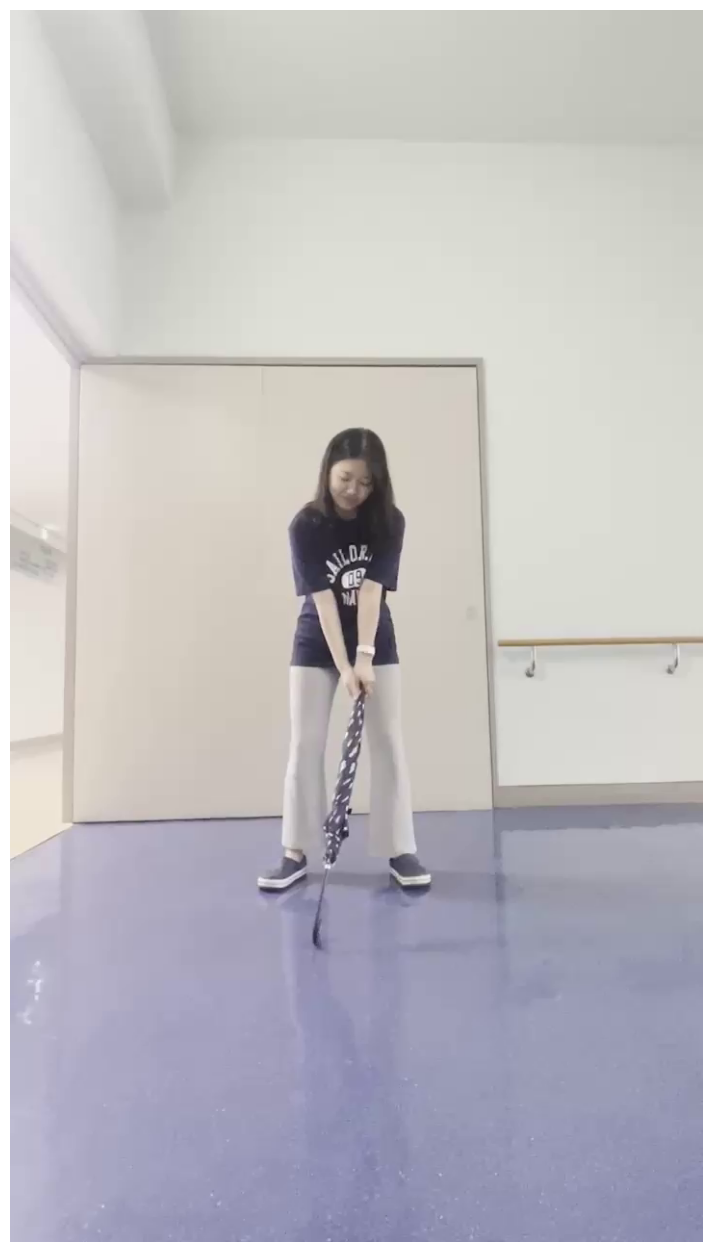

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_C_PATH))  # iter 한번 호출하면 값이 없어지고 next로 다음인자 하나씩 꺼낼수 있다.

frame = next(frame_iterator)
plot_image(frame, 16)

#load yolov7 models

In [ ]:
%cd {HOME}/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt --quiet
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt --quiet
# pull the weights from github
# --quiet : give less output

/content/yolov7


In [ ]:
DETECTION_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-e6e.pt"
POSE_MODEL_WEIGHTS_PATH = f"{HOME}/yolov7/yolov7-w6-pose.pt"

In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#gpu 사용 명령어

#load dection model

In [ ]:
from utils.general import check_img_size
from models.experimental import attempt_load

detection_model = attempt_load(weights=DETECTION_MODEL_WEIGHTS_PATH, map_location=device)

Fusing layers... 


#load pose model

In [ ]:
weigths = torch.load(POSE_MODEL_WEIGHTS_PATH, map_location=device)
pose_model = weigths["model"]
_ = pose_model.float().eval()  #eval : 문자열로 표현한 계산식을 연산이 되게 한다  ex) eval("100 + 32") == 132

if torch.cuda.is_available():
    pose_model.half().to(device)

#single frame inference

In [ ]:
DETECTION_IMAGE_SIZE = 1920
POSE_IMAGE_SIZE = 960
STRIDE = 64
CONFIDENCE_TRESHOLD = 0.25
IOU_TRESHOLD = 0.65

#pre process

In [ ]:
from utils.datasets import letterbox
from torchvision import transforms

import numpy as np


def detection_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    img = letterbox(frame, DETECTION_IMAGE_SIZE, STRIDE, auto=True)[0] # (1920, 64)로 이미지에
    # letterbox: ex)1080x1920 -> 720x1280으로 이미지 변형 할떄 남는 부분 채워주기
    img = img[:, :, ::-1].transpose(2, 0, 1)
    #transpose()<-axis 순서를 바꿔준다 (원래는 0,1,2) shape 바뀜
    img = np.ascontiguousarray(img) #make the array to a contiguous array in memory
    img = torch.from_numpy(img).to(device).float()  # 실수형 numpy
    img /= 255.0
    if img.ndimension() == 3:  # 3차원이면!
        img = img.unsqueeze(0)  # 1인 차원을 생성 총4차원이 되는듯
    return img

def pose_pre_process_frame(frame: np.ndarray, device: torch.device) -> torch.Tensor:
    image = letterbox(frame, POSE_IMAGE_SIZE, stride=STRIDE, auto=True)[0] #(960, 64)
    image = transforms.ToTensor()(image)
    # numpy 배열이미지에서 pytorch image tensor로 변환하는 과정
    #(h,w,c -> c,h,w), 0~255 -> 0~1
    image = torch.tensor(np.array([image.numpy()]))

    if torch.cuda.is_available():
        image = image.half().to(device)

    return image

#post process

In [ ]:
from typing import Tuple

from utils.general import non_max_suppression_kpt, non_max_suppression
from utils.plots import output_to_keypoint

import numpy as np


def clip_coords(boxes: np.ndarray, img_shape: Tuple[int, int]):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0] = np.clip(boxes[:, 0], 0, img_shape[1]) # x1
    boxes[:, 1] = np.clip(boxes[:, 1], 0, img_shape[0]) # y1
    boxes[:, 2] = np.clip(boxes[:, 2], 0, img_shape[1]) # x2
    boxes[:, 3] = np.clip(boxes[:, 3], 0, img_shape[0]) # y2


def detection_post_process_output(
    output: torch.tensor,
    confidence_trashold: float,
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression(
        prediction=output,
        conf_thres=confidence_trashold,
        iou_thres=iou_trashold
    )
    coords = output[0].detach().cpu().numpy()  # output을 coords에 넣고
    # print(coords)
    #[[     767.25      214.91      1021.9      1021.2      0.9664           0]
    #[     711.62      945.33      805.33      1044.6     0.95268          32]]
    v_gain = scaled_image_size[0] / image_size[0]
    h_gain = scaled_image_size[1] / image_size[1]

    coords[:, 0] /= h_gain
    coords[:, 1] /= v_gain
    coords[:, 2] /= h_gain
    coords[:, 3] /= v_gain
    print(coords)
    #  [[     767.25      213.33      1021.9      1013.6      0.9664           0]
    #  [     711.62      938.38      805.33      1036.9     0.95268          32]]
    return coords
#output의 coords 좌표 반환 -> 근데 왜 coords가 4개일까..

def post_process_pose(pose: np.ndarray, image_size: Tuple, scaled_image_size: Tuple) -> np.ndarray:
    height, width = image_size
    scaled_height, scaled_width = scaled_image_size
    vertical_factor = height / scaled_height
    horizontal_factor = width / scaled_width
    result = pose.copy()
    for i in range(17):
        result[i * 3] = horizontal_factor * result[i * 3]
        result[i * 3 + 1] = vertical_factor * result[i * 3 + 1]
    return result
# 0,1, 3,4, 6,7, 9,10, 12,13,... 48,49

def pose_post_process_output(
    output: torch.tensor,
    confidence_trashold: float,
    iou_trashold: float,
    image_size: Tuple[int, int],
    scaled_image_size: Tuple[int, int]
) -> np.ndarray:
    output = non_max_suppression_kpt(
        prediction=output,
        conf_thres=confidence_trashold,
        iou_thres=iou_trashold,
        # nc=pose_model.yaml['nc'],
        # nkpt=pose_model.yaml['nkpt'],
        kpt_label=True)

    with torch.no_grad():
        output = output_to_keypoint(output)
        print(output)
        for idx in range(output.shape[0]):
            output[idx, 7:] = post_process_pose(
                output[idx, 7:],
                image_size=image_size,
                scaled_image_size=scaled_image_size
            )

    return output

In [ ]:
from utils.plots import plot_skeleton_kpts

#output으로 박스 만들고 그리기까지 해줌
def detect_annotate(image: np.ndarray, detections: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    annotated_image = image.copy()
    for x_min, y_min, x_max, y_max, confidence, class_id in detections:
        rect = Rect(
            x=float(x_min),
            y=float(y_min),
            width=float(x_max - x_min),
            height=float(y_max - y_min)
        )
        annotated_image = draw_rect(image=annotated_image, rect=rect, color=color, thickness=thickness)

    return annotated_image


def pose_annotate(image: np.ndarray, detections: np.ndarray) -> np.ndarray:
    annotated_frame = image.copy()

    for idx in range(detections.shape[0]):
        pose = detections[idx, 7:].T
        plot_skeleton_kpts(annotated_frame, pose, 3)
    print(pose)
    return annotated_frame


(1280, 720, 3)
torch.Size([1, 3, 1920, 1088])


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[     242.78      354.22      458.25      972.81     0.95131           0]
 [     334.24      704.21      381.24      1037.8     0.70013          25]
 [      334.8      705.36      380.86      946.32     0.43316          27]]


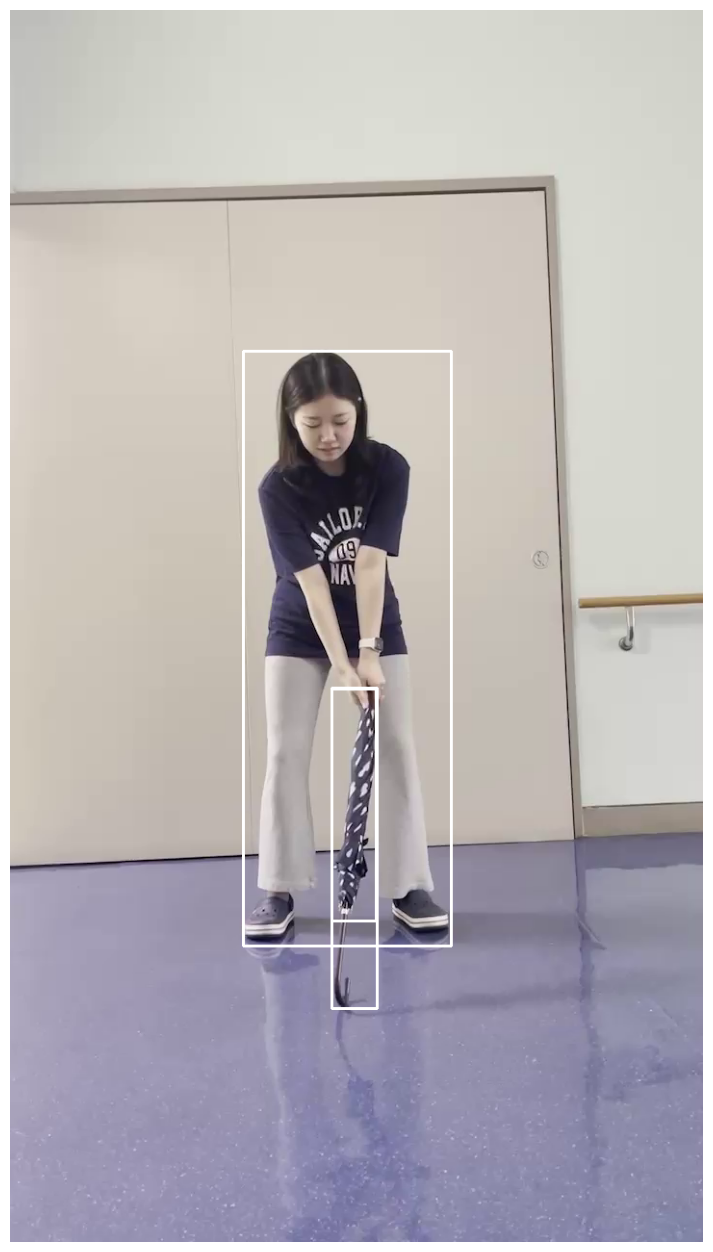

In [ ]:
COLOR = Color(r=255, g=255, b=255)


frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)

detection_pre_processed_frame = detection_pre_process_frame(
    frame=frame,
    device=device
)
print(frame.shape)  # (1080,1920,3)
print(detection_pre_processed_frame.size()) # torch.size([1,3,1088,1920])
image_size = frame.shape[:2] # (1080,1920)
scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]  # 크기 조정한 이미지(1088,1920)
# print(scaled_image_size) # (1088,1920)
with torch.no_grad():
# torxh.no_grad() : autograd engine(gradient)을 비활성화 시켜 필요한 메모리를 줄어주고 연산속도를 증가시키는 역할

    detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()  # dection모델에 dection_preprocessed_frame 넣어서 output 뽑기

    detection_output = detection_post_process_output(
        output=detection_output,
        confidence_trashold=CONFIDENCE_TRESHOLD,
        iou_trashold=IOU_TRESHOLD,
        image_size=image_size,
        scaled_image_size=scaled_image_size
    )
#x_min, y_min, x_max, y_max, confidence, class_id
%matplotlib inline
annotated_frame = detect_annotate(image=frame, detections=detection_output, color=COLOR)

plot_image(annotated_frame, 16)

In [ ]:
def process_frame_and_annotate(frame: np.ndarray) -> np.ndarray:
    pose_pre_processed_frame = pose_pre_process_frame(frame=frame.copy(), device=device)

    image_size = frame.shape[:2]
    scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

    with torch.no_grad():
        pose_output, _ = pose_model(pose_pre_processed_frame)
        print(pose_output)
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=scaled_image_size
        )
    annotated_frame = pose_annotate(image=frame, detections=pose_output)

    return annotated_frame

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))

frame = next(frame_iterator)

annotated_frame = process_frame_and_annotate(frame=frame)
print(annotated_frame.shape)
plot_image(annotated_frame, 16)


tensor([[[5.97656e+00, 6.82031e+00, 1.28281e+01,  ..., 3.42188e+00, 3.60625e+01, 1.37329e-01],
         [1.07148e+01, 7.39844e+00, 1.56250e+01,  ..., 8.98438e+00, 3.39375e+01, 1.70410e-01],
         [1.90352e+01, 7.47656e+00, 1.42656e+01,  ..., 1.37969e+01, 3.51875e+01, 1.78101e-01],
         ...,
         [4.09688e+02, 8.78438e+02, 3.61000e+02,  ..., 3.61250e+02, 9.72000e+02, 2.64648e-01],
         [4.68781e+02, 8.81562e+02, 3.58500e+02,  ..., 4.69750e+02, 9.73000e+02, 2.62207e-01],
         [5.26719e+02, 8.87703e+02, 3.66500e+02,  ..., 5.02250e+02, 9.85500e+02, 2.70752e-01]]], device='cuda:0')
[[          0           0      280.47      496.44      159.38         464     0.94204      265.25         331     0.99756      274.75      319.75     0.99609      253.75      321.75      0.9917         289      312.75     0.90625         238       319.5     0.68164       312.5       358.5     0.97266      228.12
       370.75     0.96973         302       433.5     0.93848      252.38         4

[[          0           0      297.19      513.75         189      477.75     0.92471      224.75      347.75     0.27026       223.5      339.25     0.26245      223.75       339.5     0.02153      231.38       331.5     0.83154       263.5       317.5     0.31885      248.12      373.75      0.8252       315.5
        342.5      0.8833       271.5      411.25      0.3833      349.75      393.75     0.52734      305.25      396.75     0.16528      311.75      405.75     0.24731      317.75         498     0.92871         369      486.25     0.94824      290.25         602     0.93945       341.5       593.5     0.95312
          325         708     0.88428       341.5         696     0.90479]]
[     280.94      463.67     0.27026      279.38      452.33     0.26245      279.69      452.67     0.02153      289.22         442     0.83154      329.38      423.33     0.31885      310.16      498.33      0.8252      394.38      456.67      0.8833      339.38      548.33      0.3833      43

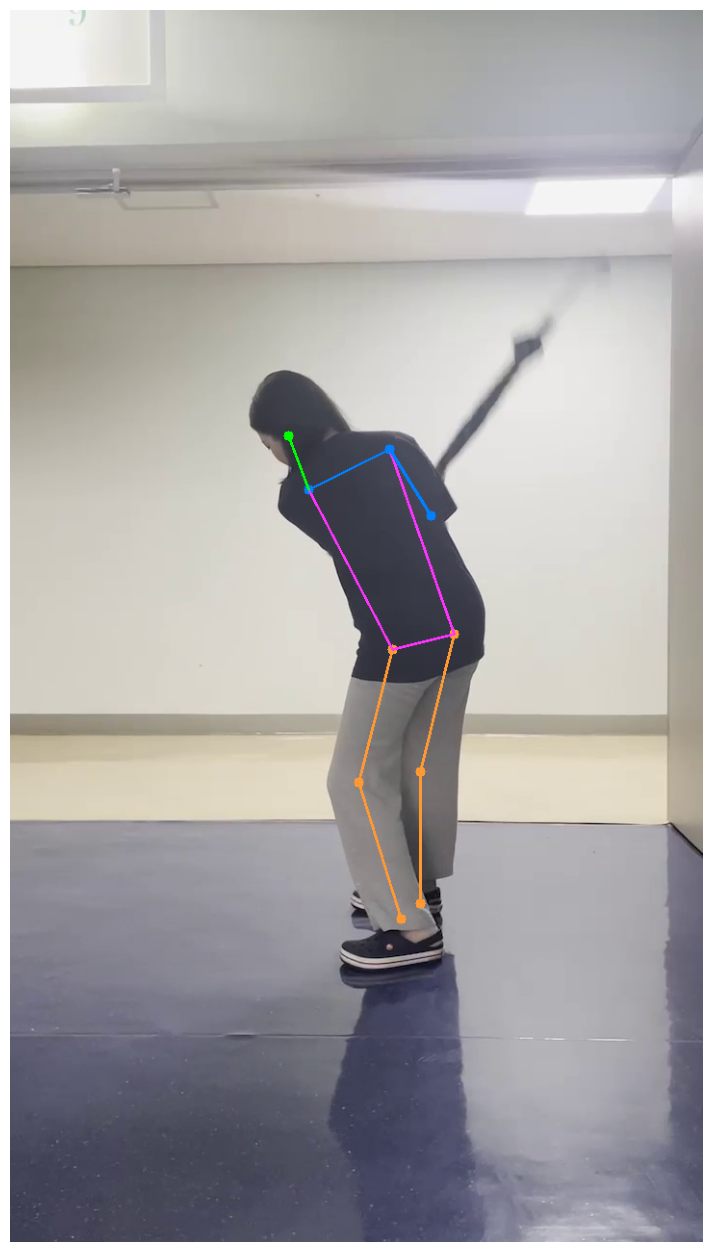

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_B_PATH))

frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)
frame = next(frame_iterator)

annotated_frame = process_frame_and_annotate(frame=frame)

plot_image(annotated_frame, 16)

#process video

In [ ]:
from dataclasses import dataclass

import cv2


"""
usage example:

video_config = VideoConfig(
    fps=30,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH,
    video_config=video_config)

for frame in frames:
    ...
    video_writer.write(frame)

video_writer.release()
"""


# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )


def get_frame_count(path: str) -> int:
    cap = cv2.VideoCapture(path)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


a_len = (get_frame_count(SOURCE_VIDEO_A_PATH))
b_len = (get_frame_count(SOURCE_VIDEO_B_PATH))
c_len = get_frame_count(SOURCE_VIDEO_C_PATH)
d_len = get_frame_count(SOURCE_VIDEO_D_PATH)
frame_count_list = (a_len, b_len, c_len, d_len)
print(frame_count_list)
frame_count_list_sort= sorted(frame_count_list)
lowest_frame = frame_count_list_sort[0]
print(lowest_frame)

(78, 90, 75, 78)
75


In [ ]:
SOURCE_VIDEO_PATH_B = SOURCE_VIDEO_B_PATH
TARGET_VIDEO_PATH_B = f"{HOME}/output/pose-estimation-synchronised-sample-b.mp4"

In [ ]:
SOURCE_VIDEO_PATH_A = SOURCE_VIDEO_A_PATH
TARGET_VIDEO_PATH_A = f"{HOME}/output/pose-estimation-synchronised-sample-a.mp4"

In [ ]:
SOURCE_VIDEO_PATH_C = SOURCE_VIDEO_C_PATH
TARGET_VIDEO_PATH_C = f"{HOME}/output/pose-estimation-synchronised-sample-c.mp4"

In [ ]:
SOURCE_VIDEO_PATH_D = SOURCE_VIDEO_D_PATH
TARGET_VIDEO_PATH_D = f"{HOME}/output/pose-estimation-synchronised-sample-d.mp4"

In [ ]:
from tqdm.notebook import tqdm

COLOR = Color(r=255, g=255, b=255)

# initiate video writer
video_config = VideoConfig(
    fps=30,
    width=1280,
    height=720)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH_B,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH_B))

total = b_len
# tqdm은 진행률 프로세스바
for frame in tqdm(frame_iterator, total=total):
    annotated_frame = frame.copy()

    with torch.no_grad():
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame,
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )
        annotated_frame = detect_annotate(
            image=annotated_frame, detections=detection_output, color=COLOR)

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame,
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
        annotated_frame = pose_annotate(
            image=annotated_frame, detections=pose_output)

        # save video frame
        video_writer.write(annotated_frame)

# close output video
video_writer.release()

  0%|          | 0/90 [00:00<?, ?it/s]

[[     250.81      366.52      494.73      1001.2     0.95284           0]
 [     214.09      706.06      317.88      887.19      0.7568          25]
 [     342.32      933.26       448.3      1016.4     0.63354          36]]
[[          0           0      298.44      513.62      184.62      478.25     0.94155       224.5         342     0.94385       224.5      331.25     0.96289       220.5       334.5     0.12964       244.5         317     0.96924      250.88      319.25     0.24597      266.25      364.25     0.96289      293.75
       348.25     0.92969       266.5       439.5      0.9375       279.5      434.25     0.78467      263.25       507.5     0.89014      261.75      500.25     0.72021       338.5      487.75     0.97998       363.5         481     0.97314      308.75         597     0.96973         334         593     0.95752
        327.5         707      0.9043         335         694     0.88916]]
[     280.62         456     0.94385      280.62      441.67     0.962

In [ ]:
from tqdm.notebook import tqdm

COLOR = Color(r=255, g=255, b=255)

# initiate video writer
video_config = VideoConfig(
    fps=25,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH_A,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH_A))

total = a_len
# tqdm은 진행률 프로세스바
for frame in tqdm(frame_iterator, total=total):
    annotated_frame = frame.copy()

    with torch.no_grad():
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame,
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )
        annotated_frame = detect_annotate(
            image=annotated_frame, detections=detection_output, color=COLOR)

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame,
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
        annotated_frame = pose_annotate(
            image=annotated_frame, detections=pose_output)

        # save video frame
        video_writer.write(annotated_frame)

# close output video
video_writer.release()

  0%|          | 0/78 [00:00<?, ?it/s]

[[     242.78      354.22      458.25      972.81     0.95131           0]
 [     334.24      704.21      381.24      1037.8     0.70013          25]
 [      334.8      705.36      380.86      946.32     0.43316          27]]
[[          0           0      280.47      496.44      159.38         464     0.94204      265.25         331     0.99756      274.75      319.75     0.99609      253.75      321.75      0.9917         289      312.75     0.90625         238       319.5     0.68164       312.5       358.5     0.97266      228.12
       370.75     0.96973         302       433.5     0.93848      252.38         447     0.93115       299.5       498.5     0.90967       280.5         508     0.90479         301       478.5     0.98389      244.12      481.75     0.98291         318       571.5     0.96143      234.75         578     0.95996
        330.5       681.5     0.88184      227.75         684     0.87939]]
[     331.56      441.33     0.99756      343.44      426.33     0.996

In [ ]:
from tqdm.notebook import tqdm

COLOR = Color(r=255, g=255, b=255)

# initiate video writer
video_config = VideoConfig(
    fps=25,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH_C,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH_C))

total = c_len
# tqdm은 진행률 프로세스바
for frame in tqdm(frame_iterator, total=total):
    annotated_frame = frame.copy()

    with torch.no_grad():
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame,
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )
        annotated_frame = detect_annotate(
            image=annotated_frame, detections=detection_output, color=COLOR)

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame,
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
        annotated_frame = pose_annotate(
            image=annotated_frame, detections=pose_output)

        # save video frame
        video_writer.write(annotated_frame)

# close output video
video_writer.release()

  0%|          | 0/75 [00:00<?, ?it/s]

[[     256.67      432.35      439.61      919.05     0.95423           0]
 [     314.38      705.95      369.63      976.55     0.62512          25]]
[[          0           0      279.25      507.56      132.88       364.5     0.92386       285.5      374.25     0.99512         294       367.5     0.99268      278.75       365.5     0.98682         304      370.25     0.84912       266.5       362.5     0.83838         312       400.5     0.98633      248.88
          401     0.98779      300.75      455.75     0.95264         263      460.75     0.96484         296      503.75     0.94385         281       511.5     0.95557         301      490.75     0.98877       257.5         491     0.98926       311.5         569     0.98242      249.38         572     0.98438
          322         654     0.95215      240.88         657     0.95508]]
[     356.88         499     0.99512       367.5         490     0.99268      348.44      487.33     0.98682         380      493.67     0.84912 

In [ ]:
from tqdm.notebook import tqdm

COLOR = Color(r=255, g=255, b=255)

# initiate video writer
video_config = VideoConfig(
    fps=25,
    width=1920,
    height=1080)
video_writer = get_video_writer(
    target_video_path=TARGET_VIDEO_PATH_D,
    video_config=video_config)

# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH_D))

total = d_len
# tqdm은 진행률 프로세스바
for frame in tqdm(frame_iterator, total=total):
    annotated_frame = frame.copy()

    with torch.no_grad():
        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame,
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )
        annotated_frame = detect_annotate(
            image=annotated_frame, detections=detection_output, color=COLOR)

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame,
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
        annotated_frame = pose_annotate(
            image=annotated_frame, detections=pose_output)

        # save video frame
        video_writer.write(annotated_frame)

# close output video
video_writer.release()

  0%|          | 0/78 [00:00<?, ?it/s]

[[     239.36      330.96      489.19      984.41     0.95976           0]
 [     194.73      684.03      323.83      913.47     0.55285          25]]
[[          0           0      291.53      493.59      191.62       486.5     0.94066      223.75      333.25     0.66797         223      323.25     0.74072         219      324.25    0.049133      243.62         306     0.92871      243.25         298     0.09552         268       336.5     0.97754         289
          314     0.94043         267       416.5     0.96191         276       401.5     0.70459      268.75      482.25     0.92871      268.75      474.25     0.65674      333.75       463.5      0.9873      360.75       455.5     0.97998         310         577     0.98877         338         570     0.97998
          323         698     0.96875       338.5       674.5     0.95654]]
[     279.69      444.33     0.66797      278.75         431     0.74072      273.75      432.33    0.049133      304.53         408     0.92871 

In [ ]:
from typing import Union

import json
import os

def create_parent_dir(file_path: str) -> None:
    file_directory = os.path.dirname(os.path.abspath(file_path))
    os.makedirs(file_directory, exist_ok=True)


def dump_json_file(file_path: str, content: Union[list, dict], **kwargs) -> None:
    create_parent_dir(file_path=file_path)
    with open(file_path, "w") as file:
        json.dump(content, file, **kwargs)


In [ ]:
def process_and_dump(source_video_path: str, target_json_path: str) -> None:
    frame_iterator = iter(generate_frames(video_file=source_video_path))
    total = a_len
    entries = []

    for frame in tqdm(frame_iterator, total=total):

        image_size = frame.shape[:2]

        #detection
        detection_pre_processed_frame = detection_pre_process_frame(
            frame=frame,
            device=device)
        detection_scaled_image_size = tuple(detection_pre_processed_frame.size())[2:]

        detection_output = detection_model(detection_pre_processed_frame)[0].detach().cpu()
        detection_output = detection_post_process_output(
            output=detection_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=detection_scaled_image_size
        )

        # pose
        pose_pre_processed_frame = pose_pre_process_frame(
            frame=frame,
            device=device)
        pose_scaled_image_size = tuple(pose_pre_processed_frame.size())[2:]

        pose_output = pose_model(pose_pre_processed_frame)[0].detach().cpu()
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=pose_scaled_image_size
        )
# tolist : to list
        entry = {
            "detection": detection_output.tolist(),
            "pose": pose_output.tolist()
        }
        entries.append(entry)

    dump_json_file(file_path=target_json_path, content=entries)

In [ ]:
process_and_dump(SOURCE_VIDEO_A_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-a.json")
process_and_dump(SOURCE_VIDEO_B_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-b.json")
process_and_dump(SOURCE_VIDEO_C_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-c.json")
process_and_dump(SOURCE_VIDEO_D_PATH, f"{HOME}/output/pose-estimation-synchronised-sample-d.json")

  0%|          | 0/78 [00:00<?, ?it/s]

[[     242.78      354.22      458.25      972.81     0.95131           0]
 [     334.24      704.21      381.24      1037.8     0.70013          25]
 [      334.8      705.36      380.86      946.32     0.43316          27]]
[[          0           0      280.47      496.44      159.38         464     0.94204      265.25         331     0.99756      274.75      319.75     0.99609      253.75      321.75      0.9917         289      312.75     0.90625         238       319.5     0.68164       312.5       358.5     0.97266      228.12
       370.75     0.96973         302       433.5     0.93848      252.38         447     0.93115       299.5       498.5     0.90967       280.5         508     0.90479         301       478.5     0.98389      244.12      481.75     0.98291         318       571.5     0.96143      234.75         578     0.95996
        330.5       681.5     0.88184      227.75         684     0.87939]]
[[     242.39      354.47      458.44      972.69     0.95201         

  0%|          | 0/78 [00:00<?, ?it/s]

[[     250.81      366.52      494.73      1001.2     0.95284           0]
 [     214.09      706.06      317.88      887.19      0.7568          25]
 [     342.32      933.26       448.3      1016.4     0.63354          36]]
[[          0           0      298.44      513.62      184.62      478.25     0.94155       224.5         342     0.94385       224.5      331.25     0.96289       220.5       334.5     0.12964       244.5         317     0.96924      250.88      319.25     0.24597      266.25      364.25     0.96289      293.75
       348.25     0.92969       266.5       439.5      0.9375       279.5      434.25     0.78467      263.25       507.5     0.89014      261.75      500.25     0.72021       338.5      487.75     0.97998       363.5         481     0.97314      308.75         597     0.96973         334         593     0.95752
        327.5         707      0.9043         335         694     0.88916]]
[[     251.28       366.1      494.73      1002.7     0.95562         

  0%|          | 0/78 [00:00<?, ?it/s]

[[     256.67      432.35      439.61      919.05     0.95423           0]
 [     314.38      705.95      369.63      976.55     0.62512          25]]
[[          0           0      279.25      507.56      132.88       364.5     0.92386       285.5      374.25     0.99512         294       367.5     0.99268      278.75       365.5     0.98682         304      370.25     0.84912       266.5       362.5     0.83838         312       400.5     0.98633      248.88
          401     0.98779      300.75      455.75     0.95264         263      460.75     0.96484         296      503.75     0.94385         281       511.5     0.95557         301      490.75     0.98877       257.5         491     0.98926       311.5         569     0.98242      249.38         572     0.98438
          322         654     0.95215      240.88         657     0.95508]]
[[        257      432.36      439.28      918.99      0.9534           0]
 [     321.01      704.75      367.81      896.75     0.49364         

  0%|          | 0/78 [00:00<?, ?it/s]

[[     239.36      330.96      489.19      984.41     0.95976           0]
 [     194.73      684.03      323.83      913.47     0.55285          25]]
[[          0           0      291.53      493.59      191.62       486.5     0.94066      223.75      333.25     0.66797         223      323.25     0.74072         219      324.25    0.049133      243.62         306     0.92871      243.25         298     0.09552         268       336.5     0.97754         289
          314     0.94043         267       416.5     0.96191         276       401.5     0.70459      268.75      482.25     0.92871      268.75      474.25     0.65674      333.75       463.5      0.9873      360.75       455.5     0.97998         310         577     0.98877         338         570     0.97998
          323         698     0.96875       338.5       674.5     0.95654]]
[[     238.95      331.01       489.9      983.24     0.96104           0]
 [     217.38      680.88      325.96      894.95      0.4235         

#3D pose estimation

In [ ]:
names = [ 'person', 'bicycle ', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

In [ ]:
FRAME_WIDTH = 1920
FRAME_HEIGHT = 1080

VIEW_X_MIN = - 500
VIEW_X_MAX = 500
VIEW_Y_MIN = - 500
VIEW_Y_MAX = 500
VIEW_Z_MIN = 0
VIEW_Z_MAX = 1000

POSE_ANCHORS = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [5,6],
    [5,7],
    [6,8],
    [7,9],
    [8,10],
    [5,11],
    [6,12],
    [11,12],
    [11,13],
    [12,14],
    [13,15],
    [14,16]
]

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content/yolov7


In [ ]:
# %cd {HOME}
# !mkdir extracted_data
# %cd {HOME}/extracted_data
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P" -O pose-estimation-synchronised-sample-a.json && rm -rf /tmp/cookies.txt
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V34envDNz8877yMWtzsPKdwoLjFXASAG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V34envDNz8877yMWtzsPKdwoLjFXASAG" -O pose-estimation-synchronised-sample-b.json && rm -rf /tmp/cookies.txt


In [ ]:
# EXTRACTED_DATA_A_PATH = ("/content/yolov7/output/pose-estimation-synchronised-sample-a.json")
# EXTRACTED_DATA_B_PATH = ("/content/yolov7/output/pose-estimation-synchronised-sample-b.json")
EXTRACTED_DATA_A_PATH = ("/content/output/pose-estimation-synchronised-sample-a.json")
EXTRACTED_DATA_B_PATH = ("/content/output/pose-estimation-synchronised-sample-b.json")
EXTRACTED_DATA_C_PATH = ("/content/output/pose-estimation-synchronised-sample-c.json")
EXTRACTED_DATA_D_PATH = ("/content/output/pose-estimation-synchronised-sample-d.json")

In [ ]:
from dataclasses import dataclass
from typing import List

import numpy as np

import json


@dataclass
class FrameData:
    pose: np.ndarray
    detection: np.ndarray


def load_json(path: str) -> dict:
    with open(path) as f:
        contents = f.read()
        return json.loads(contents)


def load_extracted_data(path: str) -> List[FrameData]:
    raw = load_json(path)
    return [
        FrameData(
            pose=entry['pose'],
            detection=entry['detection']
        )
        for entry
        in raw
    ]


In [ ]:
extracted_data_a = load_extracted_data(EXTRACTED_DATA_A_PATH)
extracted_data_b = load_extracted_data(EXTRACTED_DATA_B_PATH)
extracted_data_c = load_extracted_data(EXTRACTED_DATA_C_PATH)
extracted_data_d = load_extracted_data(EXTRACTED_DATA_D_PATH)

In [ ]:
len(extracted_data_a)

78

In [ ]:
extracted_data_a

[FrameData(pose=[[0.0, 0.0, 280.46875, 496.4375, 159.375, 464.0, 0.942035436630249, 331.5625, 441.3333333333333, 0.99755859375, 343.4375, 426.3333333333333, 0.99609375, 317.1875, 429.0, 0.99169921875, 361.25, 417.0, 0.90625, 297.5, 426.0, 0.681640625, 390.625, 478.0, 0.97265625, 285.15625, 494.3333333333333, 0.9697265625, 377.5, 578.0, 0.9384765625, 315.46875, 596.0, 0.93115234375, 374.375, 664.6666666666666, 0.90966796875, 350.625, 677.3333333333333, 0.90478515625, 376.25, 638.0, 0.98388671875, 305.15625, 642.3333333333333, 0.98291015625, 397.5, 762.0, 0.96142578125, 293.4375, 770.6666666666666, 0.9599609375, 413.125, 908.6666666666666, 0.8818359375, 284.6875, 912.0, 0.87939453125]], detection=[[242.7793731689453, 354.2198791503906, 458.24749755859375, 972.8086547851562, 0.9513099789619446, 0.0], [334.24481201171875, 704.212158203125, 381.24481201171875, 1037.7808837890625, 0.700134813785553, 25.0], [334.7986145019531, 705.3571166992188, 380.85797119140625, 946.3229370117188, 0.433163

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, List, Tuple


@dataclass
class Pose:
    x: np.ndarray
    y: np.ndarray
    confidence: np.ndarray

    @classmethod
    def load(cls, data: List[float]) -> Pose:
        x, y, confidence = [], [], []
        for i in range(17):
            x.append(data[7 + i * 3])
            y.append(data[7 + i * 3 + 1])
            confidence.append(data[7 + i * 3 + 2])
        return Pose(
            x=np.array(x),
            y=np.array(y),
            confidence=np.array(confidence)
        )


@dataclass
class Pose3D:
    x: np.ndarray
    y: np.ndarray
    z: np.ndarray

    @classmethod
    def from2D(cls, pose_a: Pose, pose_b: Pose) -> Pose3D:
        return Pose3D(
            x=pose_a.x,
            y=pose_b.x,
            z=pose_a.y
        )


@dataclass
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass
class Point3D:
    x: float
    y: float
    z: float

    @property
    def int_xyz_tuple(self) -> Tuple[int, int, int]:
        return int(self.x), int(self.y), int(self.z)

    @classmethod
    def from2D(cls, point_a: Point, point_b: Point) -> Point3D:
        return Point3D(
            x=point_a.x,
            y=point_b.x,
            z=point_a.y
        )


@dataclass
class Detection:
    x_min: float
    y_min: float
    x_max: float
    y_max: float
    confidence: float
    class_id: int

    @property
    def width(self) -> float:
        return self.x_max - self.x_min

    @property
    def height(self) -> float:
        return self.y_max - self.y_min

    @property
    def center(self) -> Point:
        return Point(
            x=(self.x_min + self.x_max) / 2,
            y=(self.y_min + self.y_max) / 2
        )

    @classmethod
    def load(cls, data: List[float]) -> Detection:
        return Detection(
            x_min=float(data[0]),
            y_min=float(data[1]),
            x_max=float(data[2]),
            y_max=float(data[3]),
            confidence=float(data[4]),
            class_id=int(data[5])
        )

    @classmethod
    def filter(cls, detections: List[Detection], class_id: int) -> Optional[Detection]:
        filtered_detections = [
            detection
            for detection
            in detections
            if detection.class_id == class_id
        ]
        return filtered_detections[0] if len(filtered_detections) == 1 else None

In [ ]:
pose_a = Pose.load(extracted_data_a[10].pose[0])
extracted_data_a[0]

FrameData(pose=[[0.0, 0.0, 280.46875, 496.4375, 159.375, 464.0, 0.942035436630249, 331.5625, 441.3333333333333, 0.99755859375, 343.4375, 426.3333333333333, 0.99609375, 317.1875, 429.0, 0.99169921875, 361.25, 417.0, 0.90625, 297.5, 426.0, 0.681640625, 390.625, 478.0, 0.97265625, 285.15625, 494.3333333333333, 0.9697265625, 377.5, 578.0, 0.9384765625, 315.46875, 596.0, 0.93115234375, 374.375, 664.6666666666666, 0.90966796875, 350.625, 677.3333333333333, 0.90478515625, 376.25, 638.0, 0.98388671875, 305.15625, 642.3333333333333, 0.98291015625, 397.5, 762.0, 0.96142578125, 293.4375, 770.6666666666666, 0.9599609375, 413.125, 908.6666666666666, 0.8818359375, 284.6875, 912.0, 0.87939453125]], detection=[[242.7793731689453, 354.2198791503906, 458.24749755859375, 972.8086547851562, 0.9513099789619446, 0.0], [334.24481201171875, 704.212158203125, 381.24481201171875, 1037.7808837890625, 0.700134813785553, 25.0], [334.7986145019531, 705.3571166992188, 380.85797119140625, 946.3229370117188, 0.4331634

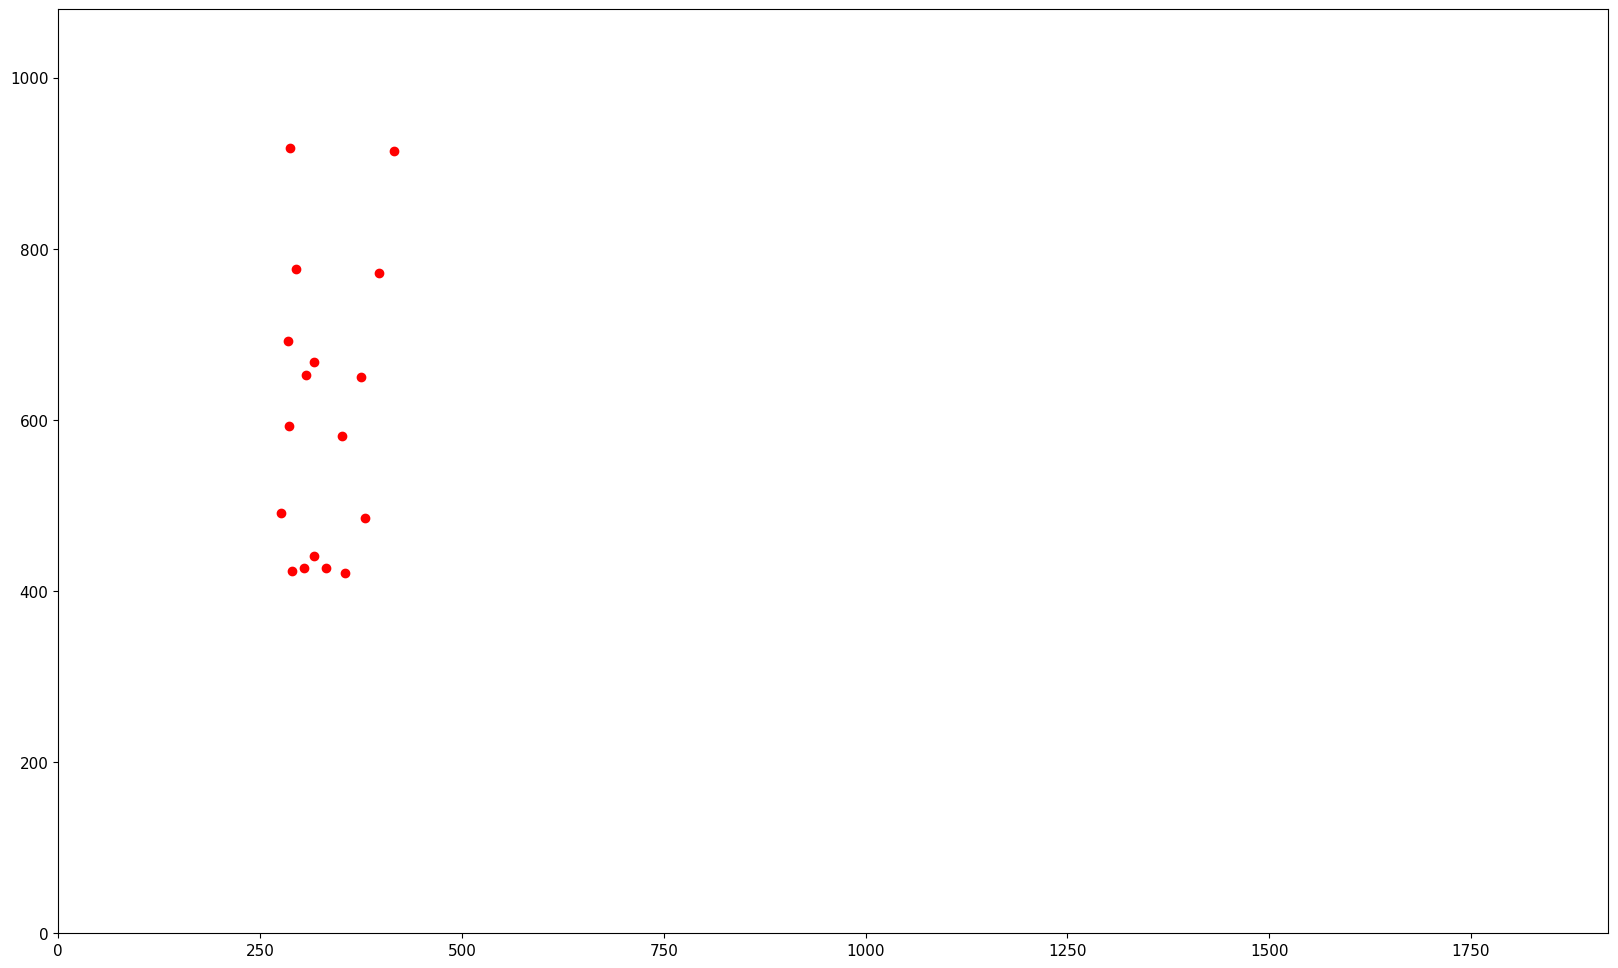

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
plt.scatter(pose_a.x, pose_a.y, color="red")
plt.xlim([0, FRAME_WIDTH])
plt.ylim([0, FRAME_HEIGHT])
plt.show()

In [ ]:
print(pose_a.x)
print(pose_a.y)

[     317.19      331.25      304.22      355.62      289.06      380.31      276.56      351.56      285.47      316.88      284.69         375      307.34      396.88      294.22      415.62       287.5]
[     441.33      427.33      427.33      421.33      423.67      485.33      491.67      581.67      593.33         668         692      649.67      652.67         772      776.67         914      917.33]


In [ ]:
pose_b = Pose.load(extracted_data_b[10].pose[0])

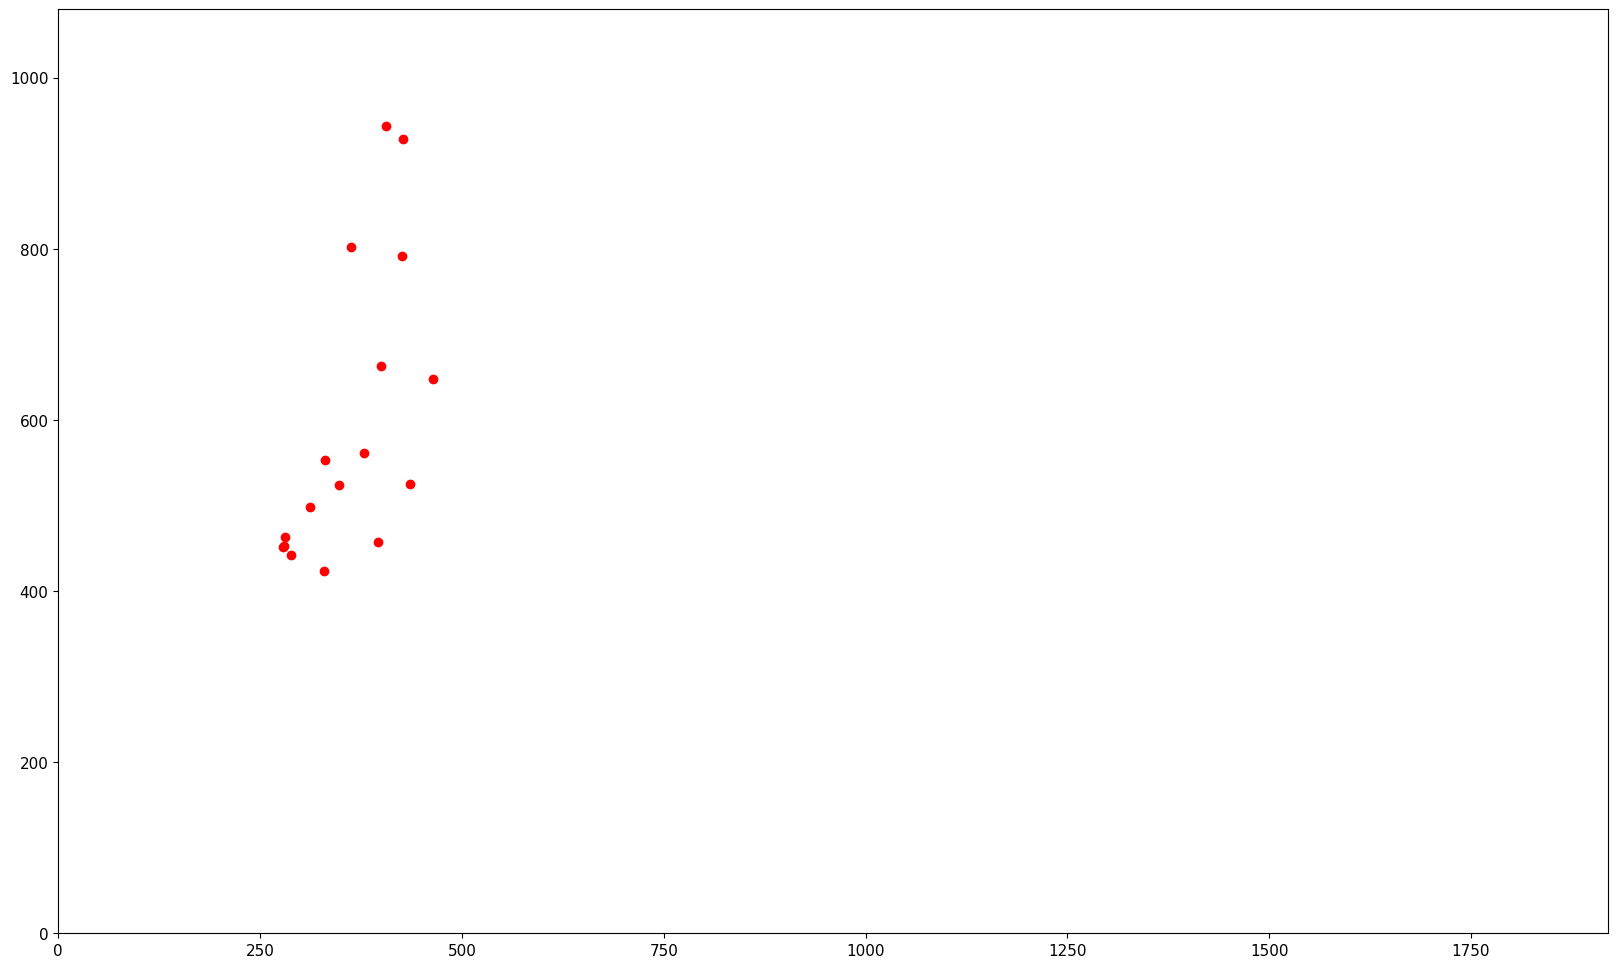

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
plt.scatter(pose_b.x, pose_b.y, color="red")
plt.xlim([0, FRAME_WIDTH])
plt.ylim([0, FRAME_HEIGHT])
plt.show()

In [ ]:
pose_c = Pose.load(extracted_data_c[10].pose[0])

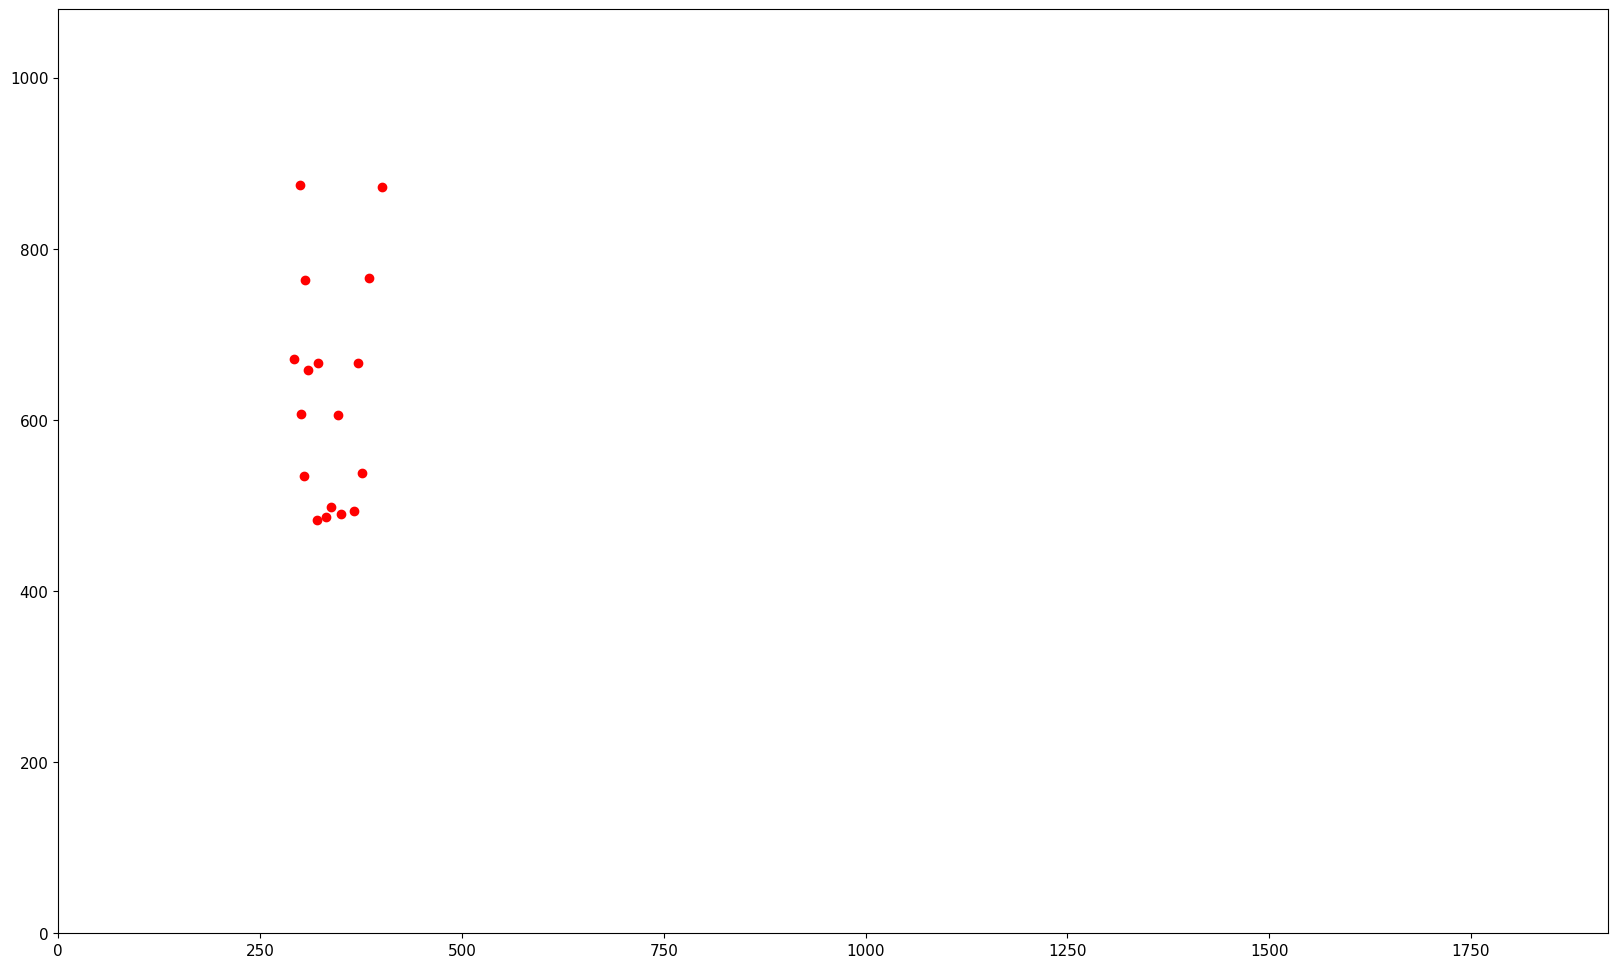

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
plt.scatter(pose_c.x, pose_c.y, color="red")
plt.xlim([0, FRAME_WIDTH])
plt.ylim([0, FRAME_HEIGHT])
plt.show()

In [ ]:
detections = [Detection.load(detection) for detection in extracted_data_a[10].detection]
detection_a = Detection.filter(detections, 0)
pose_a = Pose.load(extracted_data_a[10].pose[0])
print(detection_a)
BASELINE_HEIGHT_A = detection_a.height
BASELINE_VERTICAL_OFFSET_A = detection_a.y_max - pose_a.y.max()
print("BASELINE_HEIGHT_A", BASELINE_HEIGHT_A)
print("BASELINE_VERTICAL_OFFSET_A", BASELINE_VERTICAL_OFFSET_A)

detections = [Detection.load(detection) for detection in extracted_data_b[10].detection]
detection_b = Detection.filter(detections, 0)
pose_b = Pose.load(extracted_data_b[10].pose[0])
print(detection_b)
BASELINE_VERTICAL_OFFSET_B = detection_b.y_max - pose_b.y.max()
BASELINE_HEIGHT_B = detection_b.height
print("BASELINE_HEIGHT_B", BASELINE_HEIGHT_B)
print("BASELINE_VERTICAL_OFFSET_B", BASELINE_VERTICAL_OFFSET_B)

Detection(x_min=246.98526000976562, y_min=353.4286193847656, x_max=457.019775390625, y_max=975.1419067382812, confidence=0.9579959511756897, class_id=0)
BASELINE_HEIGHT_A 621.7132873535156
BASELINE_VERTICAL_OFFSET_A 57.80857340494799
Detection(x_min=247.31985473632812, y_min=372.26611328125, x_max=493.8512878417969, y_max=1001.42724609375, confidence=0.9511356353759766, class_id=0)
BASELINE_HEIGHT_B 629.1611328125
BASELINE_VERTICAL_OFFSET_B 57.42724609375


In [ ]:
detections = [Detection.load(detection) for detection in extracted_data_c[10].detection]
detection_c = Detection.filter(detections, 0)
pose_c = Pose.load(extracted_data_c[10].pose[0])
print(detection_c)
BASELINE_HEIGHT_C = detection_c.height
BASELINE_VERTICAL_OFFSET_C = detection_c.y_max - pose_c.y.max()
print("BASELINE_HEIGHT_C", BASELINE_HEIGHT_C)
print("BASELINE_VERTICAL_OFFSET_C", BASELINE_VERTICAL_OFFSET_C)

detections = [Detection.load(detection) for detection in extracted_data_d[10].detection]
detection_d = Detection.filter(detections, 0)
pose_d = Pose.load(extracted_data_d[10].pose[0])
print(detection_d)
BASELINE_VERTICAL_OFFSET_D = detection_d.y_max - pose_d.y.max()
BASELINE_HEIGHT_D = detection_d.height
print("BASELINE_HEIGHT_D", BASELINE_HEIGHT_D)
print("BASELINE_VERTICAL_OFFSET_D", BASELINE_VERTICAL_OFFSET_D)

Detection(x_min=256.4078369140625, y_min=433.948974609375, x_max=437.7998046875, y_max=919.1122436523438, confidence=0.9571184515953064, class_id=0)
BASELINE_HEIGHT_C 485.16326904296875
BASELINE_VERTICAL_OFFSET_C 44.44557698567712
Detection(x_min=242.36610412597656, y_min=342.1093444824219, x_max=493.07928466796875, y_max=984.2009887695312, confidence=0.8758121728897095, class_id=0)
BASELINE_HEIGHT_D 642.0916442871094
BASELINE_VERTICAL_OFFSET_D 54.86765543619799


In [ ]:
from typing import Optional, Tuple


def calibrate(
    data: FrameData,
    frame_height: int,
    baseline_pose_height: float,
    baseline_vertical_offset: float
) -> Optional[Tuple[Pose, Point]]:
    detections = [Detection.load(detection) for detection in data.detection]
    detection_person = Detection.filter(detections, 0)
    detection_ball = Detection.filter(detections, 36)

    if detection_person is None:
        return None
    # if detection_ball is None:
    #     return None
    if len(data.pose) != 1:
        return None

    pose = Pose.load(data.pose[0])
    pose.y = frame_height - pose.y

    x_shift = (pose.x.max() + pose.x.min()) / 2
    y_shift = pose.y.min() - baseline_vertical_offset
    #print(pose.y, ball_y) #-> (17개점, 93 나옴)
    pose.x = pose.x - x_shift
    pose.y = (pose.y - y_shift) * 1000 / baseline_pose_height
    return pose
# 결론적으로 x기준값이 0이 되고, y시작값이 0이 되게 교정

In [ ]:
extracted_data_a[10]

FrameData(pose=[[0.0, 0.0, 280.0625, 496.4375, 161.875, 464.0, 0.9285571575164795, 317.1875, 441.3333333333333, 0.9970703125, 331.25, 427.3333333333333, 0.99658203125, 304.21875, 427.3333333333333, 0.98876953125, 355.625, 421.3333333333333, 0.9599609375, 289.0625, 423.66666666666663, 0.59326171875, 380.3125, 485.3333333333333, 0.97021484375, 276.5625, 491.66666666666663, 0.96630859375, 351.5625, 581.6666666666666, 0.931640625, 285.46875, 593.3333333333333, 0.90966796875, 316.875, 668.0, 0.892578125, 284.6875, 692.0, 0.8720703125, 375.0, 649.6666666666666, 0.9814453125, 307.34375, 652.6666666666666, 0.98046875, 396.875, 772.0, 0.9580078125, 294.21875, 776.6666666666666, 0.95458984375, 415.625, 914.0, 0.87744140625, 287.5, 917.3333333333333, 0.87255859375]], detection=[[246.98526000976562, 353.4286193847656, 457.019775390625, 975.1419067382812, 0.9579959511756897, 0.0], [176.5419158935547, 715.6679077148438, 296.8834533691406, 887.1924438476562, 0.3830930292606354, 38.0]])

In [ ]:
pose_a = calibrate(extracted_data_a[9], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)

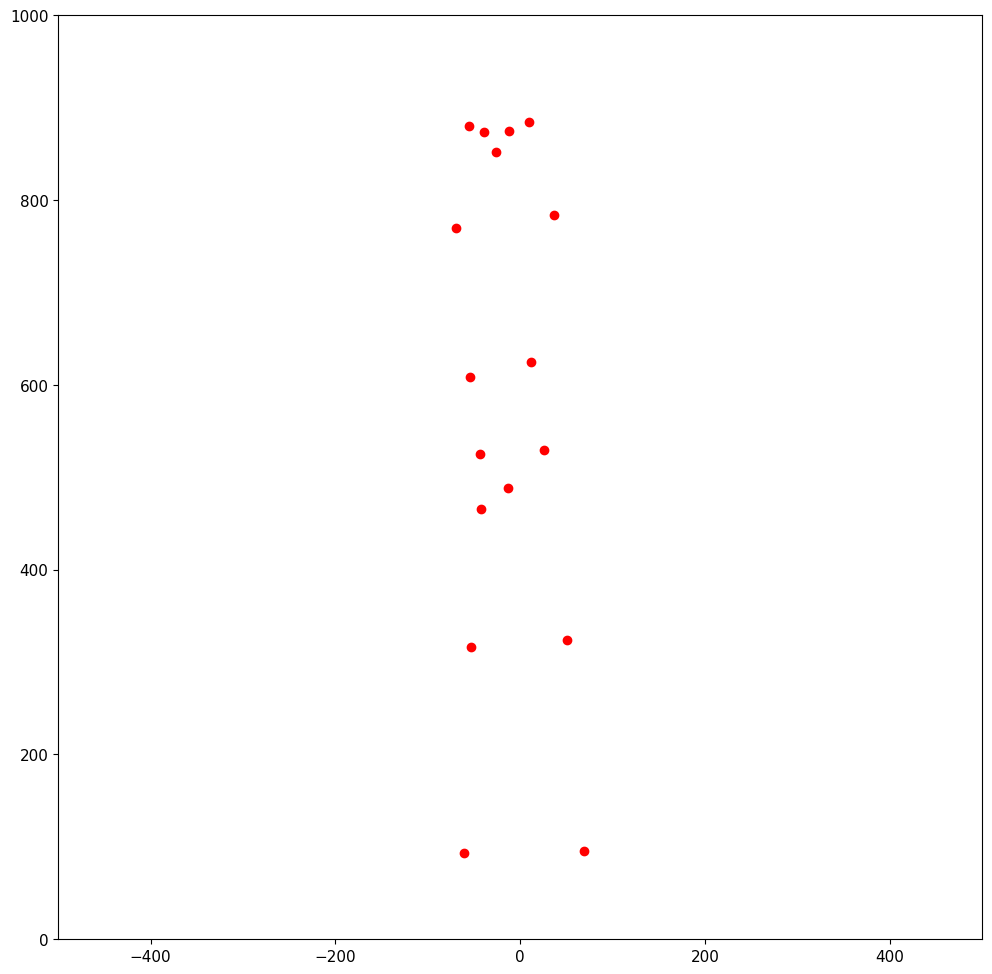

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_a.x, pose_a.y, color="red")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
extracted_data_c[10]

FrameData(pose=[[0.0, 0.0, 278.8125, 507.8125, 133.5, 364.0, 0.927217960357666, 338.4375, 498.3333333333333, 0.99658203125, 350.0, 489.66666666666663, 0.99609375, 331.5625, 486.66666666666663, 0.9833984375, 366.875, 493.3333333333333, 0.94384765625, 320.625, 483.3333333333333, 0.65673828125, 376.25, 538.0, 0.98779296875, 304.6875, 534.6666666666666, 0.98681640625, 346.25, 606.3333333333333, 0.96533203125, 300.625, 607.3333333333333, 0.955078125, 309.0625, 658.6666666666666, 0.955078125, 292.03125, 671.3333333333333, 0.94775390625, 371.875, 666.6666666666666, 0.9892578125, 321.25, 666.0, 0.98876953125, 384.375, 766.0, 0.9833984375, 305.9375, 764.0, 0.982421875, 401.5625, 872.0, 0.955078125, 300.0, 874.6666666666666, 0.953125]], detection=[[256.4078369140625, 433.948974609375, 437.7998046875, 919.1122436523438, 0.9571184515953064, 0.0], [133.79327392578125, 659.5542602539062, 307.8468322753906, 825.8506469726562, 0.4557684659957886, 38.0]])

In [ ]:
pose_c = calibrate(extracted_data_c[10], FRAME_HEIGHT, BASELINE_HEIGHT_C, BASELINE_VERTICAL_OFFSET_C)

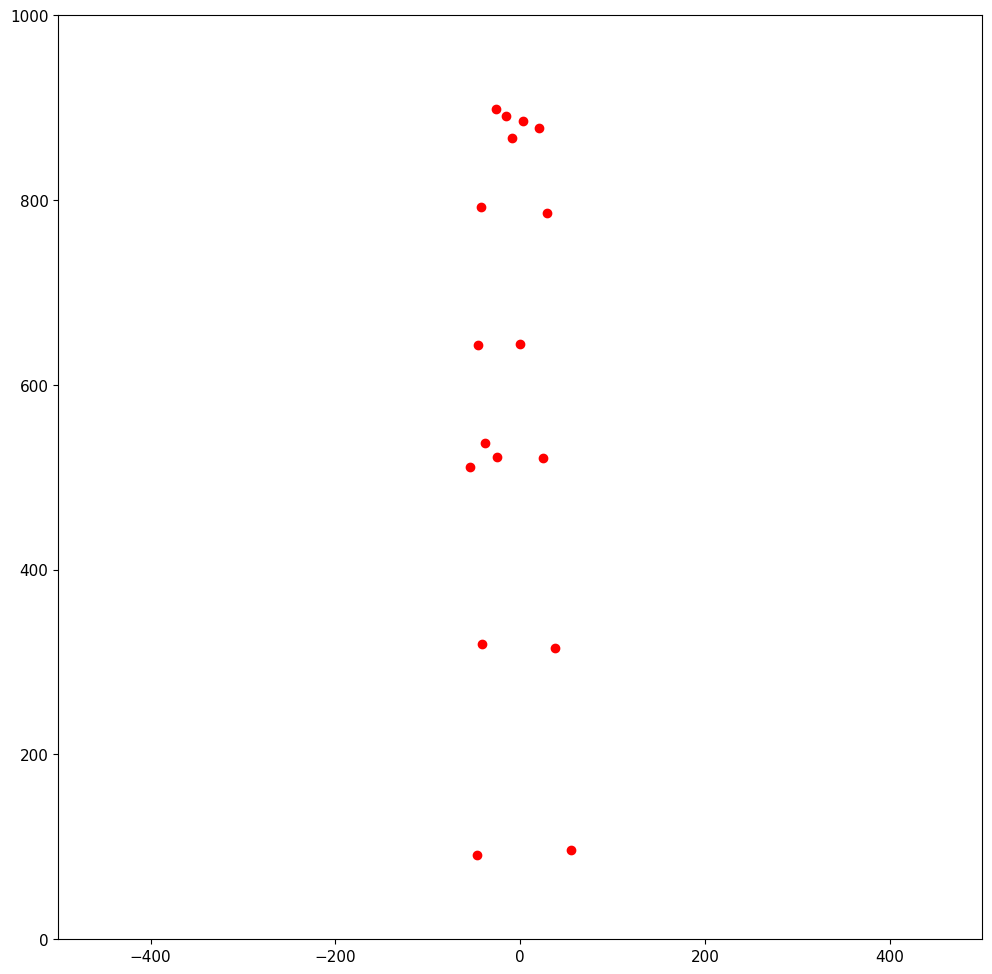

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_c.x, pose_c.y, color="red")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
extracted_data_b[10]

FrameData(pose=[[0.0, 0.0, 296.4375, 515.8125, 186.375, 473.0, 0.9434795379638672, 280.46875, 463.3333333333333, 0.254638671875, 278.4375, 452.0, 0.2467041015625, 279.21875, 452.66666666666663, 0.019989013671875, 288.28125, 442.0, 0.841796875, 328.75, 423.3333333333333, 0.2998046875, 311.5625, 498.0, 0.83349609375, 396.25, 457.0, 0.88330078125, 330.9375, 553.3333333333333, 0.425048828125, 436.25, 525.3333333333333, 0.52880859375, 348.125, 524.0, 0.193115234375, 378.75, 561.3333333333333, 0.25537109375, 400.3125, 663.3333333333333, 0.9296875, 463.75, 648.0, 0.947265625, 363.125, 802.6666666666666, 0.9375, 426.25, 791.3333333333333, 0.94970703125, 405.625, 944.0, 0.87841796875, 427.1875, 928.0, 0.89697265625]], detection=[[247.31985473632812, 372.26611328125, 493.8512878417969, 1001.42724609375, 0.9511356353759766, 0.0], [342.37542724609375, 932.8671264648438, 449.2261962890625, 1016.9380493164062, 0.6471835374832153, 36.0], [443.8412780761719, 303.3166198730469, 624.0272827148438, 500.3

In [ ]:
pose_b = calibrate(extracted_data_b[10], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

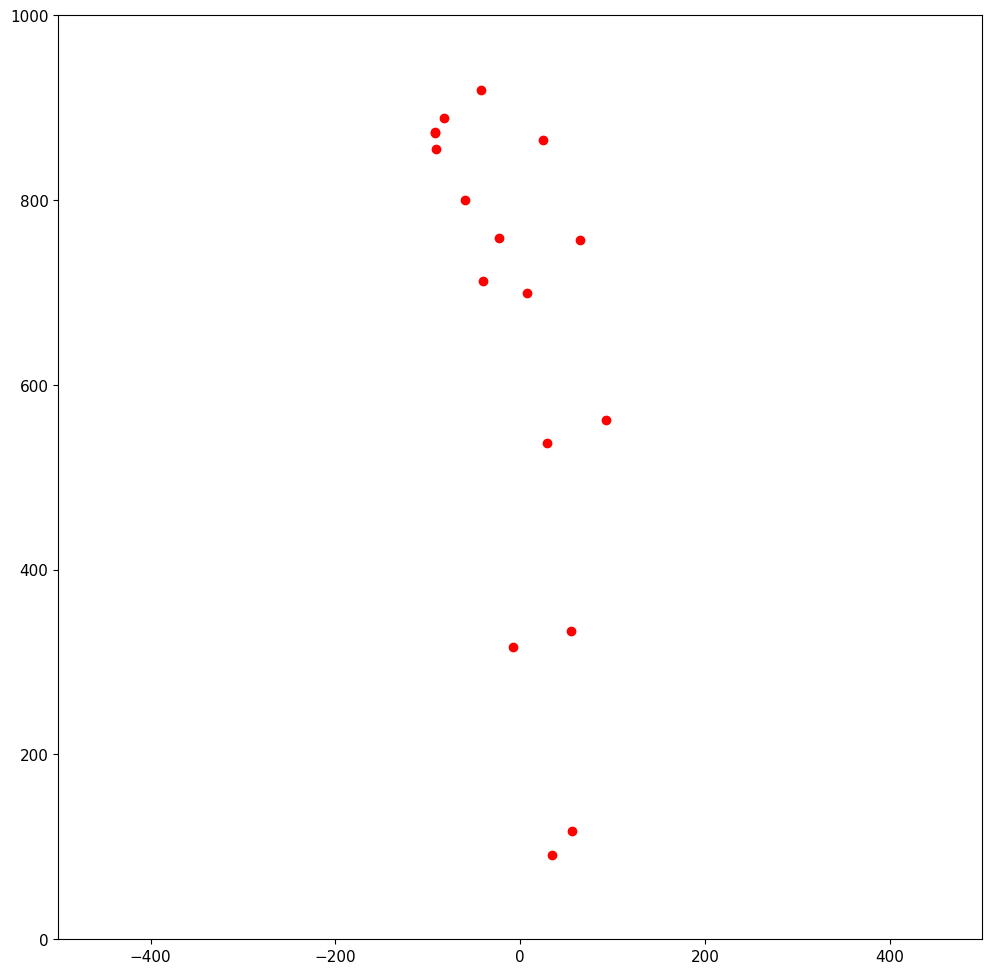

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_b.x, pose_b.y, color="red")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()


In [ ]:
extracted_data_d[10]

FrameData(pose=[[0.0, 0.0, 330.96875, 496.9375, 267.5, 481.25, 0.9035260677337646, 291.25, 450.66666666666663, 0.02508544921875, 286.875, 440.0, 0.01467132568359375, 290.3125, 438.3333333333333, 0.005428314208984375, 282.5, 424.66666666666663, 0.2445068359375, 328.4375, 393.3333333333333, 0.343017578125, 305.9375, 460.0, 0.86572265625, 401.5625, 428.66666666666663, 0.916015625, 331.875, 536.6666666666666, 0.69091796875, 437.8125, 513.3333333333333, 0.876953125, 353.125, 489.0, 0.5205078125, 508.125, 487.0, 0.7685546875, 390.0, 629.6666666666666, 0.97314453125, 456.25, 617.3333333333333, 0.98046875, 360.9375, 777.3333333333333, 0.97265625, 427.5, 765.3333333333333, 0.97998046875, 402.5, 929.3333333333333, 0.9228515625, 428.4375, 912.6666666666666, 0.93798828125]], detection=[[242.36610412597656, 342.1093444824219, 493.07928466796875, 984.2009887695312, 0.8758121728897095, 0.0], [450.96771240234375, 435.0651550292969, 596.0421142578125, 529.2826538085938, 0.32392439246177673, 38.0]])

In [ ]:
pose_d = calibrate(extracted_data_d[10], FRAME_HEIGHT, BASELINE_HEIGHT_D, BASELINE_VERTICAL_OFFSET_D)

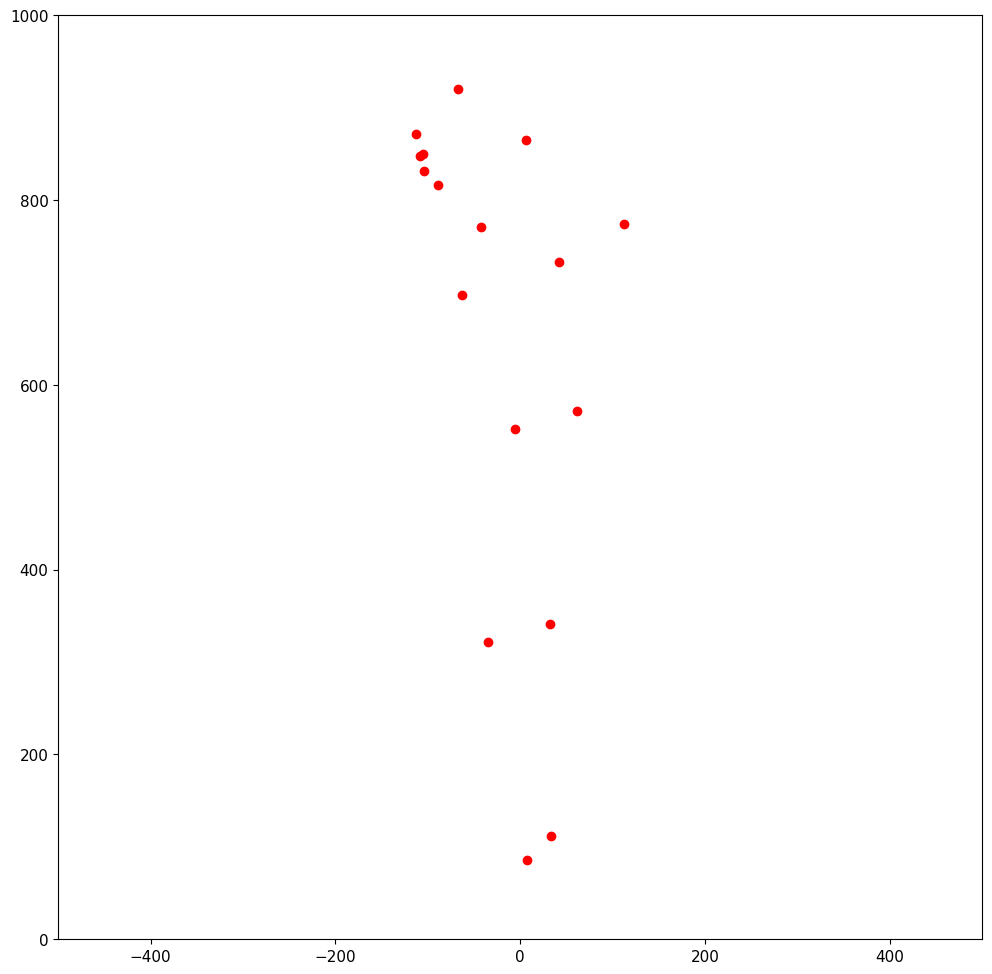

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_d.x, pose_d.y, color="red")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()


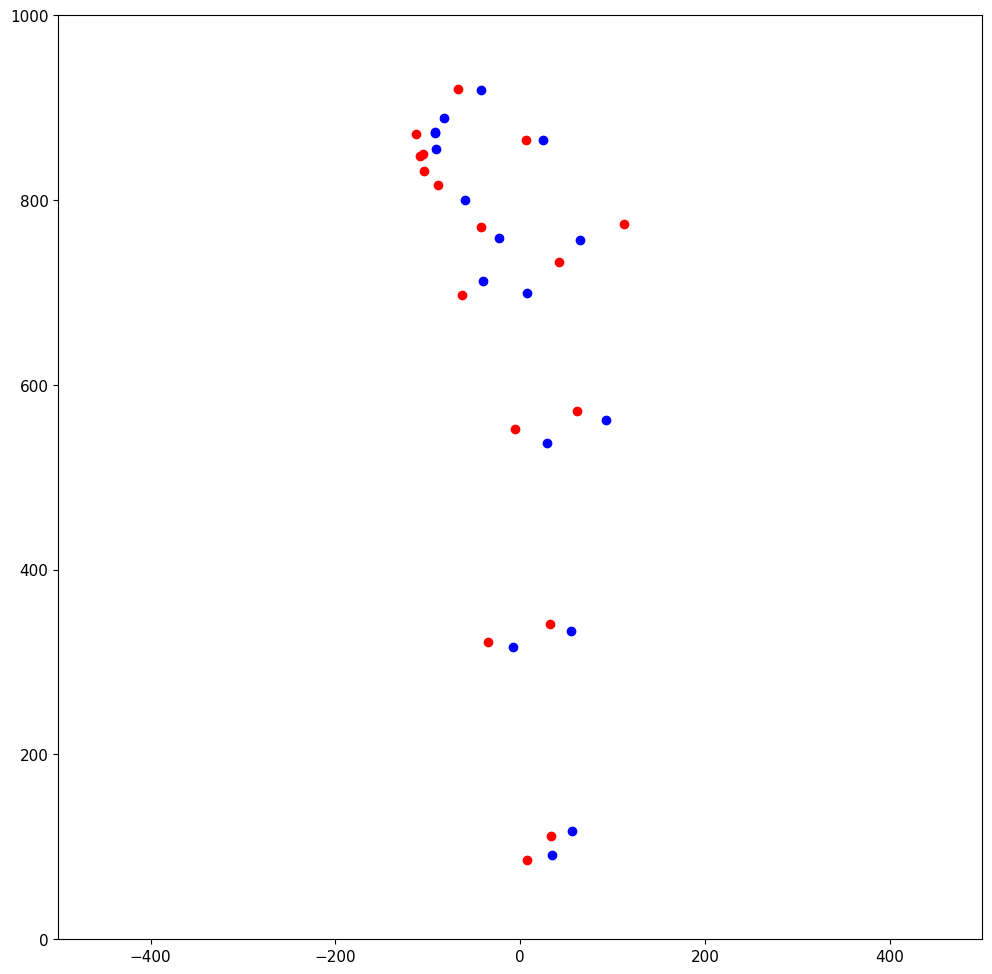

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_d.x, pose_d.y, color="red")
plt.scatter(pose_b.x, pose_b.y, color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()


In [ ]:
pose_d = calibrate(extracted_data_d[9], FRAME_HEIGHT, BASELINE_HEIGHT_D, BASELINE_VERTICAL_OFFSET_D)

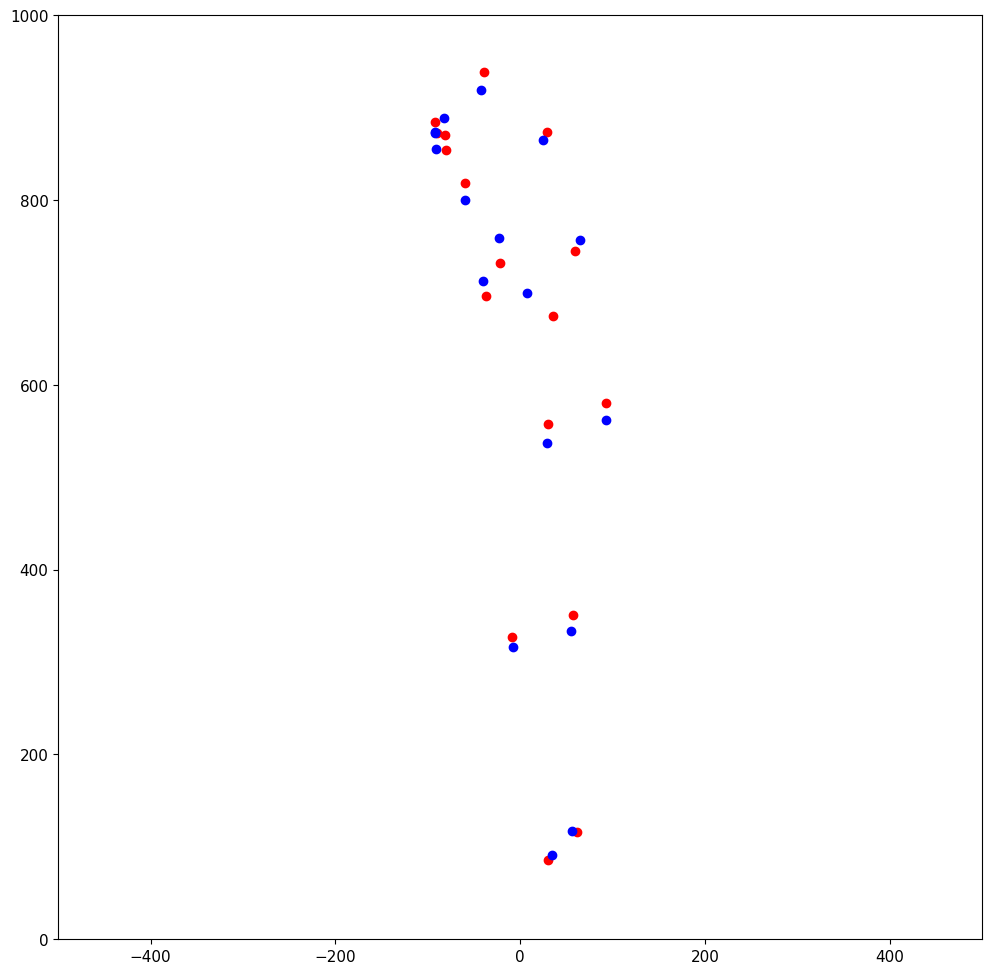

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_d.x, pose_d.y, color="red")
plt.scatter(pose_b.x, pose_b.y, color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()


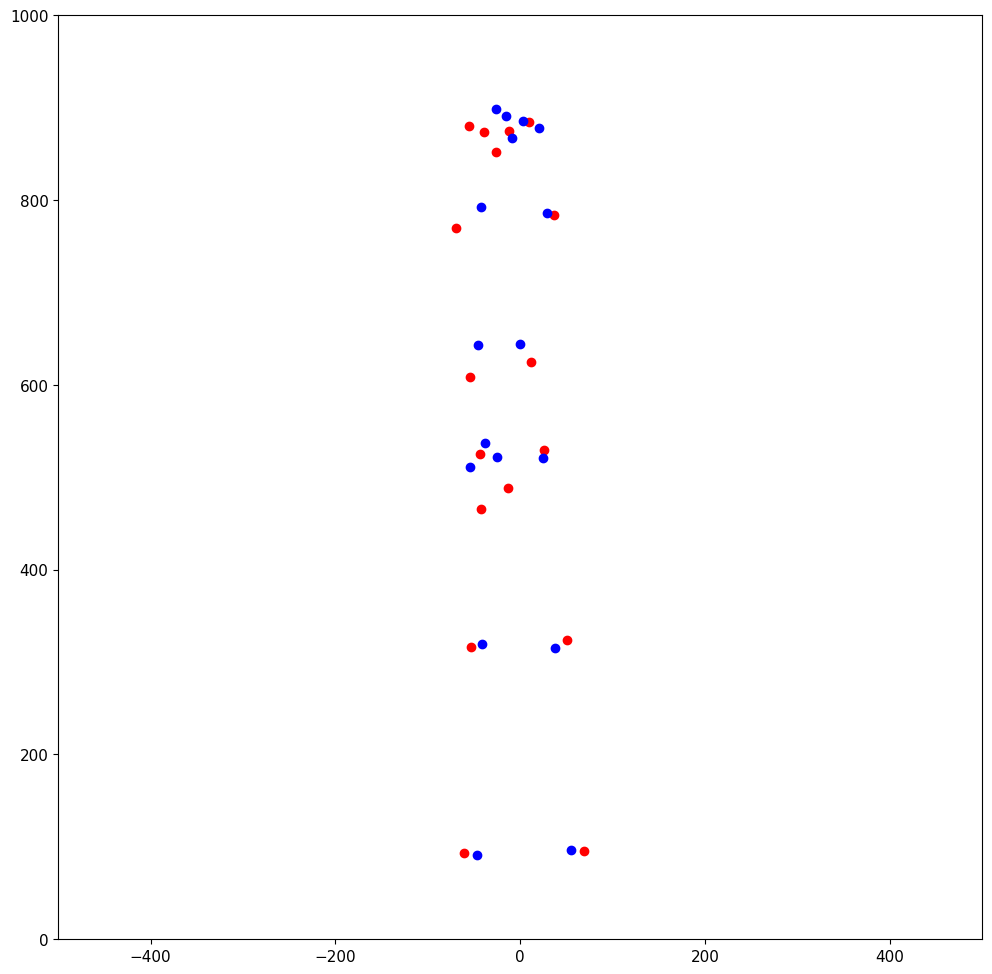

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_a.x, pose_a.y, color="red")
plt.scatter(pose_c.x, pose_c.y, color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
pose_a = calibrate(extracted_data_a[10], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
pose_b = calibrate(extracted_data_b[10], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)
pose_c = calibrate(extracted_data_c[10], FRAME_HEIGHT, BASELINE_HEIGHT_C, BASELINE_VERTICAL_OFFSET_C)
pose_d = calibrate(extracted_data_d[10], FRAME_HEIGHT, BASELINE_HEIGHT_D, BASELINE_VERTICAL_OFFSET_D)

#point_a는 여기서 공을 의미
pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b)
pose3d_1 = Pose3D.from2D(pose_a=pose_c, pose_b=pose_d)

In [ ]:
from typing import Tuple, List

from collections import deque



class Trace:
    def __init__(self, history: int = 10):
        self.x = deque(maxlen=history)
        self.y = deque(maxlen=history)
        self.z = deque(maxlen=history)

    def append(self, x: float, y: float, z: float):
        self.x.append(x)
        self.y.append(y)
        self.z.append(z)

    def get_state(self) -> Tuple[List[float], List[float], List[float]]:
        return list(self.x), list(self.y), list(self.z)

#3D pose estimation

In [ ]:
from typing import Optional
import matplotlib.pyplot as plt
import random

def draw_3d(
    pose3d: Pose3D,
    angle: int = 0,
    save_path: Optional[str] = None,
    ball_trace: Optional[Trace] = None,
    foot_1_trace: Optional[Trace] = None,
    foot_2_trace: Optional[Trace] = None,
) -> None:
    print(pose3d.z[0])
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.axes.set_xlim3d(left=VIEW_X_MIN, right=VIEW_X_MAX)
    ax.axes.set_ylim3d(bottom=VIEW_Y_MIN, top=VIEW_Y_MAX)
    ax.axes.set_zlim3d(bottom=VIEW_Z_MIN, top=VIEW_Z_MAX)

    for pose_anchor in POSE_ANCHORS:
        ax.plot(pose3d.x[pose_anchor], pose3d.y[pose_anchor], pose3d.z[pose_anchor], color="#ffffff", linewidth=5)

    if ball_trace is not None:
        ball_trace_x, ball_trace_y, ball_trace_z = ball_trace.get_state()
        ax.plot(ball_trace_x, ball_trace_y, ball_trace_z, color="#e84a5f", linewidth=2)

    if foot_1_trace is not None:
        foot_1_trace_x, foot_1_trace_y, foot_1_trace_z = foot_1_trace.get_state()
        ax.plot(foot_1_trace_x, foot_1_trace_y, foot_1_trace_z, color="#fecea8", linewidth=2)

    if foot_2_trace is not None:
        foot_2_trace_x, foot_2_trace_y, foot_2_trace_z = foot_2_trace.get_state()
        ax.plot(foot_2_trace_x, foot_2_trace_y, foot_2_trace_z, color="#fecea8", linewidth=2)

    ax.scatter(pose3d.x, pose3d.y, pose3d.z, color="#ffffff")
    ax.view_init(30, 45 + angle*2)  # 3d이미지 각도 변화

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close(fig)

858.6089187143532


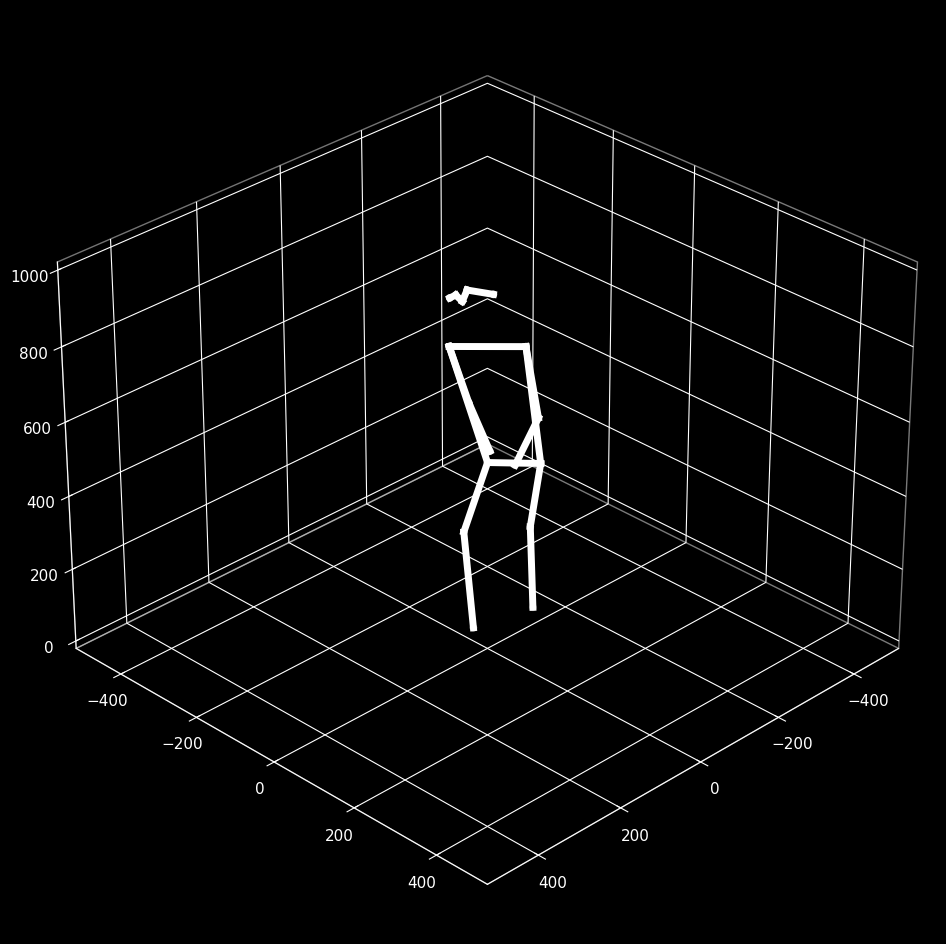

In [ ]:
draw_3d(pose3d)

853.2473904968649


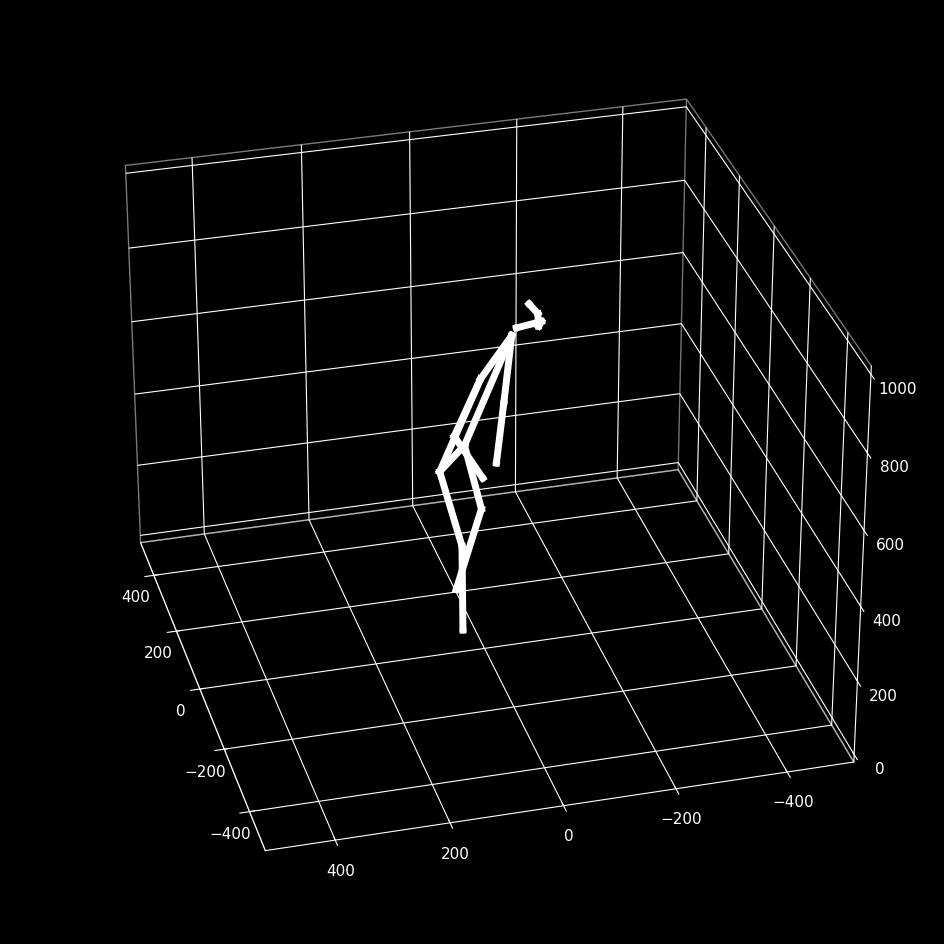

In [ ]:
pose_a = calibrate(extracted_data_a[6], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)

pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b)

draw_3d(pose3d, 60)

In [ ]:
OUTPUT_DIR = "frames"
%cd {HOME}
!mkdir -p $OUTPUT_DIR

/content/yolov7


In [ ]:
from tqdm.notebook import trange
list_nose = []

def generate_frames(start=0, end=100):
    foot_1_trace = Trace(10)
    foot_2_trace = Trace(10)
    for i in trange(start, end):
        a = calibrate(extracted_data_a[i], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
        b = calibrate(extracted_data_b[i], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

        if a is None or b is None:
            continue

        pose_a= a
        pose_b = b

        pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b)
        foot_1_trace.append(x=pose3d.x[-1], y=pose3d.y[-1], z=pose3d.z[-1])
        foot_2_trace.append(x=pose3d.x[-2], y=pose3d.y[-2], z=pose3d.z[-2])

        file_name = "file%04d.png" % i
        draw_3d(pose3d, angle=i // 2, save_path=f"{HOME}/{OUTPUT_DIR}/{file_name}", foot_1_trace=foot_1_trace, foot_2_trace=foot_2_trace)


In [ ]:
generate_frames(0, a_len-1)

  0%|          | 0/77 [00:00<?, ?it/s]

850.0304735663719
850.0304735663719
850.0304735663719
849.494320744623
851.6389320316182
852.711237675116
853.2473904968649
852.7112376751159
854.8558489621113
852.1750848533671
858.6089187143532
856.464307427358
857.0004602491067
858.0727658926043
858.6089187143532
858.0727658926043
858.6089187143532
858.0727658926045
858.0727658926043
855.928154605609
852.1750848533671
853.2473904968647
851.6389320316182
844.6689453488833
846.8135566358789
850.5666263881207
850.0304735663719
848.4220151011253
847.3497094576276
847.3497094576276
847.8858622793763
846.8135566358787
844.6689453488834
845.2050981706321
843.5966397053859
846.8135566358789
843.5966397053857
849.494320744623
852.1750848533671
855.9281546056088
855.928154605609
857.5366130708554
859.6812243578507
857.5366130708555
859.1450715361019
861.8258356448462
875.7658090103159
889.7057823757856
897.2119218802695
920.8026460372184
914.9049649979811
909.007283958744
903.6457557412556
916.5134234632276
924.0195629677113
929.9172440069486

In [ ]:
import re
path = "/content/yolov7/frames"
paths = [os.path.join(path , i ) for i in os.listdir(path) if re.search(".png$", i )]
## 정렬 작업
store1 = []
store2 = []
for i in paths :
    if len(i) == 19 :
        store2.append(i)
    else :
        store1.append(i)

paths = list(np.sort(store1)) + list(np.sort(store2))
#len('ims/2/a/2a.2710.png')
pathOut = 'abc1.mp4'
fps = 10
import cv2
frame_array = []
for idx , path in enumerate(paths) :
    if (idx % 2 == 0) | (idx % 5 == 0) :
        continue
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

In [ ]:
!pip install dtaidistance

125.69053610670942


(<Figure size 800x550 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

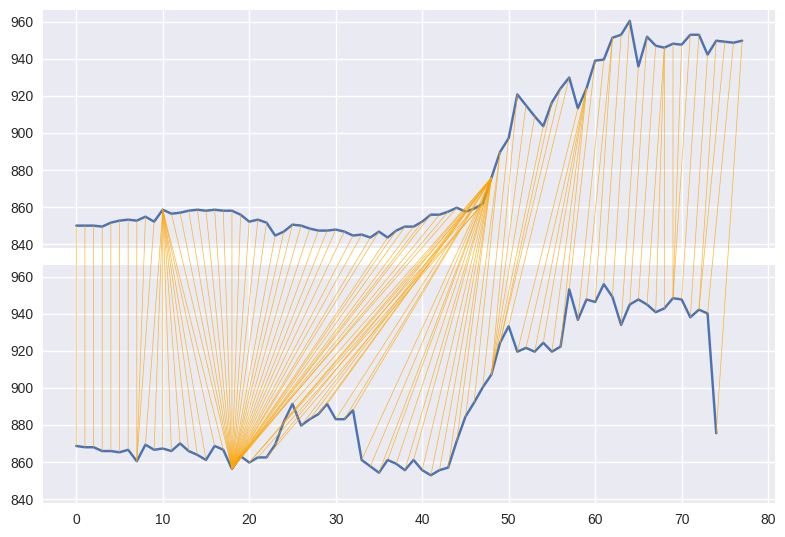

In [ ]:
from dtaidistance import dtw
distance = dtw.distance(list_a_x, list_c_x)
print(distance)
from dtaidistance import dtw_visualisation as dtwvis
dtwvis.plot_warping(list_a_x, list_c_x, path = dtw.warping_path(list_a_x, list_c_x))